# Generate Figure of Merit based dataset

This notebook is to generate a set of DR2-lite style `.par` and `.tim` files based on a figure of merit (FoM).
We include functions for a burst with memory (BWM) and stochastic gravitational wave background (gwb) FoM.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import copy
import os, glob
import json
import matplotlib.pyplot as plt
import libstempo as t2
from enterprise.signals import utils
import IPTA_DR2_analysis.utils as dr2u

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Update paths to reflect your usage.

In [5]:
project_path = '/vast/palmer/home.grace/bbl29/IPTA_DR2_analysis'
DR2dir = os.path.abspath('/vast/palmer/home.grace/bbl29/DR2/')  # path to data for Docker image
datadir = os.path.join(DR2dir, 'release/VersionB')
lite_dir = os.path.join(project_path, 'data/lite_partim')  # cleaned/combined par/tim files

# 1) clean up `.par` and `.tim` files

## make list of pulsar names for later

In [6]:
psrlist = []
psrs = glob.glob(datadir + '/J*')
for psr in psrs:
    name = psr.split('/')[-1]
    psrlist.append(name)
psrlist.sort()
psrlist

['J0023+0923',
 'J0030+0451',
 'J0034-0534',
 'J0218+4232',
 'J0340+4130',
 'J0437-4715',
 'J0610-2100',
 'J0613-0200',
 'J0621+1002',
 'J0645+5158',
 'J0711-6830',
 'J0751+1807',
 'J0900-3144',
 'J0931-1902',
 'J1012+5307',
 'J1022+1001',
 'J1024-0719',
 'J1045-4509',
 'J1455-3330',
 'J1600-3053',
 'J1603-7202',
 'J1614-2230',
 'J1640+2224',
 'J1643-1224',
 'J1713+0747',
 'J1721-2457',
 'J1730-2304',
 'J1732-5049',
 'J1738+0333',
 'J1741+1351',
 'J1744-1134',
 'J1747-4036',
 'J1751-2857',
 'J1801-1417',
 'J1802-2124',
 'J1804-2717',
 'J1824-2452A',
 'J1832-0836',
 'J1843-1113',
 'J1853+1303',
 'J1857+0943',
 'J1903+0327',
 'J1909-3744',
 'J1910+1256',
 'J1911+1347',
 'J1911-1114',
 'J1918-0642',
 'J1923+2515',
 'J1939+2134',
 'J1944+0907',
 'J1949+3106',
 'J1955+2908',
 'J2010-1323',
 'J2017+0603',
 'J2019+2425',
 'J2033+1734',
 'J2043+1711',
 'J2124-3358',
 'J2129-5721',
 'J2145-0750',
 'J2214+3000',
 'J2229+2643',
 'J2302+4442',
 'J2317+1439',
 'J2322+2057']

## clean `.par` files

In [7]:
# note these are cleaned, fully combined parfiles
# all it does is add DM1, DM2 to par if not present already
parfiles = glob.glob(datadir + '/J*/*IPTADR2.par')

for p in parfiles:
    name = p.split('/')[-2]
    outfile = os.path.join(lite_dir, '{}.par'.format(name))
    dr2u.clean_par(p, outfile)

## combine `.tim` files

In [8]:
timfiles = glob.glob(datadir + '/J*/*IPTADR2.tim')

for t in timfiles:
    name = t.split('/')[-2]
    outfile = os.path.join(lite_dir, '{}.tim'.format(name))
    dr2u.combine_tim(t, outfile)

# 2) Figure of Merit Calculation

Calculate the FoM for each pulsar for each PTA that observes it.
Both of these FoMs are for white noise dominated pulsars, which is not true... You may want to modify them.

## Burst with Memory FoM
From van Haasteren & Levin (2010) the uncertainty on the measurement of the BWM amplitude is estimated for even cadence, white-noise dominated observations.  Madison *et al*. (2014) interpret this as the minimum amplitude for a 1-$\sigma$ detection.

$$ \sigma_{h_0} = h_{min} \sim \sigma_\star \,\Delta t^{1/2}\, T^{-3/2}, $$

where $\sigma_\star$ is the TOA measurment uncertainty for a single pulsar or the response weighted root-mean-squared of uncertainty for all pulsars in a network, $\Delta t$ is the observing cadence, and $T$ the observation baseline.

To maximize the sensitivity of our array we want to minimize $\sigma_{h_0}$.
We define our figure of merit for pulsar selection as:
$$ \mathrm{FoM}_{bwm} = \frac{1}{\sigma_{h_0}} = \sqrt{\frac{T^{3}}{\left<{\sigma_{TOA}}\right>^2 \, \Delta t}} $$

## Gravitational Wave Background FoM

From GWB signal-to-noise ratio (SNR) scaling laws in Siemens, et al. 2013. 

The weak signal scaling law, used at the December 2017 busyweek at Flatiron CCA in NYC gives a FoM of:

$$ \mathrm{FoM}_{gwb} = \frac{T^\frac{13}{3}}{\left<{\sigma_{TOA}}\right>^2 \, \Delta t} $$

And the intermediate regime sclaing gives the following Figure of Merit:

$$ \mathrm{FoM}_{gwb} = T^\frac{1}{2}\left(\frac{1}{\left<{\sigma_{TOA}}\right>^2 \, \Delta t}\right)^\frac{1}{2\beta} $$

In [9]:
def bwm_FoM(Tobs, dt, TOAerr):
    """BWM FoM = 1/sig_h0
    """
    return np.sqrt(Tobs**3/dt) / TOAerr

def gwb_FoM_weak(Tobs, dt, TOAerr):
    """GWB FoM from SNR scaling laws
    """
    return Tobs**(13/3) / TOAerr**2 / dt 

def gwb_FoM_inter(Tobs, dt, TOAerr):
    """GWB FoM from SNR scaling laws
    """
    return Tobs**(1/2) * (TOAerr**2 * dt) ** (-1/(2*13/3)) 

In [10]:
# analysis tag to use in filenames
tag = "inter_gwb_7yrcut"
my_FoM = gwb_FoM_inter  # function alias for FoM of choice

# filter parameters
BW = 1.1
DM_window = 10 # days

# best PSR selection parameters
Tmin = 7.0  # yrs
sigmax = 10.0  # us

In [11]:
ptas = ['PPTA', 'EPTA', 'NANOGrav']
backends = {'NANOGrav': 
                ['327_ASP', '430_ASP', 'L-wide_ASP', 'S-wide_ASP',
                 '327_PUPPI', '430_PUPPI', 'L-wide_PUPPI',  'S-wide_PUPPI',
                 'Rcvr_800_GASP', 'Rcvr1_2_GASP',
                 'Rcvr_800_GUPPI', 'Rcvr1_2_GUPPI',
                ],
            'PPTA': 
                ['PDFB_10CM', 'PDFB_20CM', 'PDFB_40CM',
                 'CPSR2_20CM', 'CPSR2_50CM',
                 'WBCORR_10CM', 'WBCORR_20CM',
                ],
                
            'EPTA': 
                ['EFF.EBPP.1360', 'EFF.EBPP.1410', 'EFF.EBPP.2639',
                 'JBO.DFB.1400', 'JBO.DFB.1520',
                 'NRT.BON.1400', 'NRT.BON.1600', 'NRT.BON.2000',
                 'WSRT.P1.328', 'WSRT.P1.328.C', 'WSRT.P1.323.C',
                 'WSRT.P1.382', 'WSRT.P1.382.C', 'WSRT.P1.367.C',
                 'WSRT.P1.840', 'WSRT.P1.840.C',
                 'WSRT.P1.1380', 'WSRT.P1.1380.C',
                 'WSRT.P1.1380.1',
                 'WSRT.P1.1380.2', 'WSRT.P1.1380.2.C',
                 'WSRT.P1.2273.C',
                ]
           }  # backends to use for each PTA, values for `-group` flag

### Backend Notes:
#### NANOGrav

legacy, not used (`-group` flag)
```
kaspi
kaspi23 (-be mk3_23m, mk2_23)
kaspi14 (-be mk3_14m, mk2_14, mk3_14r)
L-band_Mark3a
L-band_Mark3b
L-band_Mark4
S-band_Mark4
L-band_ABPP
S-band_ABPP
```

#### PPTA

backend list for `-f` flag
```
['1050CM_PDFB1', '1050CM_PDFB2', '1050CM_PDFB3', '1050CM_PDFB4',
 '1050CM_WBCORR',
 'H-OH_CPSR2m', 'H-OH_CPSR2n', 'H-OH_PDFB1',
 'MULTI_CPSR2m', 'MULTI_CPSR2n',
 'MULTI_PDFB1', 'MULTI_PDFB2', 'MULTI_PDFB3', 'MULTI_PDFB4',
 'MULTI_WBCORR',
]
```
small number of TOAs
```
CPSR2_40CM -- J0437 & J0711 & J1045 & J2129 TOA total <3 TOAs / psr
PDFB1_early_10CM -- J1824-2452A -- 7 TOAs total
PDFB1_early_20CM -- J1824-2452A -- 1 TOA
PDFB_50CM -- J0437 & J1045, 2 TOAs total
PDFB1_20CM -- J1824-2452A, 4 TOAs total
PDFB1_10CM -- J1824-2452A, 13 TOAs total
WBCORR_20CM -- 11 Parkes PSRs, 30 TOAs for J0437, rest with <10 (still used... should it be?)
```
there are some backends with `legacy` in the name... I'm not using those.  They have lots of missing metadata.
```
PKS.fptm.20cm-legacy
PKS.s2.20cm-legacy
PKS.cpsr1.20cm_legacy
PKS.cpsr2.20cm_legacy
PKS.AFB.20cm_legacy
PKS.cpsr2.50cm_legacy
```

#### EPTA

possible legacy, only used for single freq J1939
```
NRT.DDS.1400
```
small number of TOAs
```
JBO.DFB.5000 -- J1713, 4 TOAs

```

### Construct `FoM_dict` (takes a long time, skip if already saved)

Runs `filter_psr()` for each pulsar for each PTA, computing the FoM.

In [12]:
redo = False

dict_file = f'{project_path}/FoM_output/FoM_{tag}_dict.json'  # where to save FoM dictionary
data_file = f'{project_path}/FoM_output/FoM_{tag}.dat'  # plain text file of FoM data

In [13]:
if redo or not os.path.isfile(dict_file):
    FoM_dict = {}
    fout = open(data_file, 'w')
    fout.write('{:11}{:9}{:9}{:9}{:9}{:9}{:12}\n'
               .format(' Pulsar', ' PTA', ' raw_Tobs', '  mf_Tobs', '  TOAerr', '  cadence', '      FoM'))

    for psrName in psrlist:
        FoM_dict[psrName] = {}
    
        parfile = os.path.join(lite_dir, '{}.par'.format(psrName))
        timfile = os.path.join(lite_dir, '{}.tim'.format(psrName))
        psr = t2.tempopulsar(parfile, timfile, maxobs=30000)
        plt.figure(figsize=(10,4),dpi=300)
        for i, pta in enumerate(ptas):
            if pta in psr.flagvals('pta'):
                FoM_dict[psrName][pta] = {}
                filt = {'pta':[pta], 'group':backends[pta]}
                psr = dr2u.filter_psr(psr, bw=BW, dt=DM_window, filter_dict=filt, plot=False)
                nix = psr.flagvals('pta') == pta
                plt.scatter(psr.toas()[nix], psr.freqs[nix], color=f'C{i}', label=pta, alpha=0.1, s=20)
                plt.scatter(psr.toas()[~psr.deletedmask()], psr.freqs[~psr.deletedmask()], color=f'C{i}',
                            alpha=1, label=f'{pta} filtered', edgecolor='k', lw=0.3, s=20)
                
                idx = ~psr.deletedmask()
                Tobs_raw = (psr.toas().max()-psr.toas().min()) / 365.25
                if len(psr.toas()[idx]) > 0:
                    U, _ = utils.create_quantization_matrix(psr.toas()[idx]*86400, dt=86400, nmin=1)
                    cadence = (psr.toas()[idx].max() - psr.toas()[idx].min()) / U.shape[1] # mean dt
                    Tobs = (psr.toas()[idx].max()-psr.toas()[idx].min()) / 365.25
                    sigma = 1 / np.mean(1/psr.toaerrs[idx])  # harmonic mean TOAerr
                    FoM = my_FoM(Tobs, cadence, sigma)
                else:
                    Tobs = 0
                    sigma = np.inf
                    cadence = np.inf
                    FoM = 0
                fout.write('{:11}{:9}{:9.2f}{:9.2f}{:9.2f}{:9.2f}{:9.2f}\n'
                            .format(psrName, pta, Tobs_raw, Tobs, sigma, cadence, FoM))
                FoM_dict[psrName][pta]['Tobs'] = Tobs
                FoM_dict[psrName][pta]['dt'] = cadence
                FoM_dict[psrName][pta]['sigma'] = sigma
                FoM_dict[psrName][pta]['FoM'] = FoM
        del psr
        plt.legend(loc='best', frameon=False)
        plt.title(psrName)
    fout.close()

In [14]:
if redo:
    psrName = 'J1713+0747'
    parfile = os.path.join(lite_dir, '{}.par'.format(psrName))
    timfile = os.path.join(lite_dir, '{}.tim'.format(psrName))
    psr = t2.tempopulsar(parfile, timfile, maxobs=30000)
    plt.figure(figsize=(10,4),dpi=300)
    for i, pta in enumerate(ptas):
        if pta in psr.flagvals('pta'):
            filt = {'pta':[pta], 'group':backends[pta]}
            psr = dr2u.filter_psr(psr, bw=BW, dt=DM_window, filter_dict=filt, plot=False)
            nix = psr.flagvals('pta') == pta
            plt.scatter(psr.toas()[nix], psr.freqs[nix], color=f'C{i}', label=pta, alpha=0.1, s=20)
            plt.scatter(psr.toas()[~psr.deletedmask()], psr.freqs[~psr.deletedmask()], color=f'C{i}',
                        alpha=1, label=f'{pta} filtered', edgecolor='k', lw=0.3, s=20)
    del psr
    plt.legend(loc='best', frameon=False)
    plt.title(psrName)

### save `FoM_dict` as `json` database for later usage

In [15]:
if redo or not os.path.isfile(dict_file):

    # convert FoM_dict to python float (json can't handle numpy.float128)
    for psr in FoM_dict.keys():
        for pta in FoM_dict[psr].keys():
            for key in FoM_dict[psr][pta].keys():
                FoM_dict[psr][pta][key] = float(FoM_dict[psr][pta][key])

    with open(dict_file, 'w') as fout:
        json.dump(FoM_dict, fout, sort_keys=True, indent=4, separators=(',', ': '))

# 3) Select pulsars to use

Use only PSRs with `Tmin` yrs of multi-frequency data.  Pick one PTA per pulsar.

In [16]:
#dict_file = 'FoM_output/FoM_{}_dict.json'.format(tag)  # FoM dictionary, same as above
with open(dict_file, 'r') as fin:
    FoM_dict = json.load(fin)

In [17]:
FoM_dict

{'J0023+0923': {'NANOGrav': {'FoM': 0.8888613661457506,
   'Tobs': 2.301883192684355,
   'dt': 30.027244147427165,
   'sigma': 1.8512933543948156}},
 'J0030+0451': {'EPTA': {'FoM': 1.6679448155502439,
   'Tobs': 7.4184082745952775,
   'dt': 9.781854232115252,
   'sigma': 2.677166532322692},
  'NANOGrav': {'FoM': 1.7276258377537923,
   'Tobs': 8.772806682182862,
   'dt': 53.40446067778817,
   'sigma': 1.4149120740401786}},
 'J0034-0534': {'EPTA': {'FoM': 1.4659612286721682,
   'Tobs': 9.865055281775353,
   'dt': 40.035682685204975,
   'sigma': 4.293333076739396}},
 'J0218+4232': {'EPTA': {'FoM': 1.7291887971665953,
   'Tobs': 13.538396553955659,
   'dt': 16.107163978281122,
   'sigma': 6.570054966216863}},
 'J0340+4130': {'NANOGrav': {'FoM': 0.6508764032146075,
   'Tobs': 1.681809868127254,
   'dt': 14.982464739840964,
   'sigma': 5.123475846650768}},
 'J0437-4715': {'PPTA': {'FoM': 4.373933890876382,
   'Tobs': 10.77720048634095,
   'dt': 7.526524813835626,
   'sigma': 0.10512017420365

In [18]:
psrdict = {}

for psrname in psrlist:
    best = {'pta':None, 'Tobs':0, 'FoM':0}
    for pta in ptas:
        try:
            this = FoM_dict[psrname][pta]
            if this['Tobs'] > Tmin and this['sigma'] < sigmax and this['FoM'] > best['FoM']:
                best = {'pta':pta, 'Tobs':this['Tobs'], 'FoM':this['FoM']}
        except KeyError:
            pass
    if best['pta'] is not None:
        psrdict.update({psrname: {'pta':[best['pta']], 'group':backends[best['pta']]}})
        print('{}: {pta:8}, T = {Tobs:5.2f} yr, FoM = {FoM:6.2f}'.format(psrname, **best))
print(f'{len(psrdict.keys())} Pulsars total')

J0030+0451: NANOGrav, T =  8.77 yr, FoM =   1.73
J0034-0534: EPTA    , T =  9.87 yr, FoM =   1.47
J0218+4232: EPTA    , T = 13.54 yr, FoM =   1.73
J0437-4715: PPTA    , T = 10.78 yr, FoM =   4.37
J0613-0200: EPTA    , T = 13.67 yr, FoM =   2.31
J0621+1002: EPTA    , T =  7.50 yr, FoM =   1.19
J1012+5307: EPTA    , T = 13.13 yr, FoM =   2.27
J1022+1001: EPTA    , T =  7.35 yr, FoM =   1.62
J1024-0719: EPTA    , T =  7.49 yr, FoM =   1.58
J1455-3330: NANOGrav, T =  9.22 yr, FoM =   1.47
J1600-3053: EPTA    , T =  7.39 yr, FoM =   2.27
J1640+2224: NANOGrav, T =  8.89 yr, FoM =   2.13
J1643-1224: EPTA    , T =  7.07 yr, FoM =   1.81
J1713+0747: EPTA    , T = 13.91 yr, FoM =   3.94
J1744-1134: PPTA    , T = 10.69 yr, FoM =   2.91
J1857+0943: NANOGrav, T =  8.87 yr, FoM =   2.08
J1909-3744: PPTA    , T = 10.82 yr, FoM =   4.12
J1918-0642: NANOGrav, T =  9.02 yr, FoM =   1.73
J1939+2134: EPTA    , T = 12.51 yr, FoM =   4.90
J2145-0750: EPTA    , T =  7.06 yr, FoM =   1.93
J2317+1439: NANOGrav

In [19]:
E,N,P = 0,0,0
for val in psrdict.values():
    val = val['pta']
    if 'EPTA' in val:
        E += 1
    elif 'NANOGrav' in val:
        N += 1
    elif 'PPTA' in val:
        P += 1
print(' EPTA - {:2d}\n   NG - {:2d}\n PPTA - {:2d}'.format(E,N,P))

 EPTA - 12
   NG -  6
 PPTA -  3


In [20]:
# save `psrdict` to file
fname = f'{project_path}/psrdicts/FoM_{tag}_psrs.json'
with open(fname, 'w') as fout:
    json.dump(psrdict, fout, sort_keys=True, indent=4, separators=(',', ': '))

# 4) Create filtered par and tim files for DR2-lite analysis

In [35]:
fname = f'{project_path}/psrdicts/FoM_{tag}_psrs.json'
with open(fname, 'r') as fin:
    FoM_dict = json.load(fin)

In [22]:
# directory where you want the dataset saved... change for your usage
rundir = os.path.join(project_path, 'data/lite_partim_final')

# make sure min_toas is the same
dr2u.make_dataset(psrdict, indir=lite_dir, outdir=rundir,
                  bw=BW, dt=DM_window, min_toas=10, plot=False)

Working on PSR J0030+0451
Keeping TOAs corresponding to pta ['NANOGrav']
Keeping TOAs corresponding to group ['327_ASP', '430_ASP', 'L-wide_ASP', 'S-wide_ASP', '327_PUPPI', '430_PUPPI', 'L-wide_PUPPI', 'S-wide_PUPPI', 'Rcvr_800_GASP', 'Rcvr1_2_GASP', 'Rcvr_800_GUPPI', 'Rcvr1_2_GUPPI']
Running multi-frequency filter
Cutting 912 TOAs
Turning off fit for ['JUMP1', 'JUMP2', 'JUMP3', 'JUMP4', 'JUMP5', 'JUMP6', 'JUMP7']
[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[observatory.C:272] Warning: Assuming site 'g' means 'eff'


Results for PSR J0030+0451


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points 

Cutting 620 TOAs
Turning off fit for ['JUMP7']
[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J0218+4232


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       0.602600908342063         0.602600908342063         1.7406e-09    0             Y
RAJ (hms)       02:18:06.3573069           02:18:06.3573069         2.3935e-05    0            
DECJ (rad)      0.742430979362267         0.742430979362267        

Working on PSR J0613-0200
Keeping TOAs corresponding to pta ['EPTA']
Keeping TOAs corresponding to group ['EFF.EBPP.1360', 'EFF.EBPP.1410', 'EFF.EBPP.2639', 'JBO.DFB.1400', 'JBO.DFB.1520', 'NRT.BON.1400', 'NRT.BON.1600', 'NRT.BON.2000', 'WSRT.P1.328', 'WSRT.P1.328.C', 'WSRT.P1.323.C', 'WSRT.P1.382', 'WSRT.P1.382.C', 'WSRT.P1.367.C', 'WSRT.P1.840', 'WSRT.P1.840.C', 'WSRT.P1.1380', 'WSRT.P1.1380.C', 'WSRT.P1.1380.1', 'WSRT.P1.1380.2', 'WSRT.P1.1380.2.C', 'WSRT.P1.2273.C']
Running multi-frequency filter
Cutting 8547 TOAs
Turning off fit for ['JUMP15', 'JUMP17', 'JUMP18', 'JUMP19', 'JUMP20', 'JUMP21', 'JUMP22', 'JUMP23', 'JUMP24', 'JUMP25', 'JUMP26', 'JUMP27', 'JUMP28', 'JUMP29', 'JUMP30', 'JUMP31', 'JUMP32', 'JUMP33', 'JUMP34', 'JUMP35', 'JUMP36']
All TOAs are being jumped!
Setting JUMP6 as reference jump.
[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/temp

-----
ECC = 4.50231485200526e-06 +/- 9.04345594280132e-08
OM  = 36.9912087220683 +/- 1.4687005739295 degrees
T0  = 53862.9898649085 +/- 0.00488960029745922
------------------------------------
Total proper motion = 10.505 +/- 0.011393 mas/yr
Total time span = 4992.417 days = 13.668 years

Tempo2 usage
Units:                 TCB (tempo2)
Time ephemeris:        IF99 (tempo2)
Troposphere corr.?     Yes (tempo2)
Dilate freq?           Yes (tempo2)
Electron density (1AU) 4
Solar system ephem     DE436
Time scale             TT(BIPM2015)
Binary model           T2
In here writing a new parameter file: /vast/palmer/home.grace/bbl29/IPTA_DR2_analysis/data/lite_partim_final/J0613-0200.par
Notice: There were 1 warnings. Summaries are shown below, check logs for full details.
Warning #1: PSR J0613-0200 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

Worki

Cutting 1076 TOAs
Turning off fit for ['JUMP3', 'JUMP11', 'JUMP12', 'JUMP13', 'JUMP14', 'JUMP15', 'JUMP16', 'JUMP17', 'JUMP18', 'JUMP19', 'JUMP20', 'JUMP21', 'JUMP22', 'JUMP23', 'JUMP24', 'JUMP25', 'JUMP26', 'JUMP27', 'JUMP28', 'JUMP29', 'JUMP30']
All TOAs are being jumped!
Setting JUMP6 as reference jump.
[preProcess.C:158] Warning: PSR J1022+1001 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J1022+1001


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------


Working on PSR J1024-0719
Keeping TOAs corresponding to pta ['EPTA']
Keeping TOAs corresponding to group ['EFF.EBPP.1360', 'EFF.EBPP.1410', 'EFF.EBPP.2639', 'JBO.DFB.1400', 'JBO.DFB.1520', 'NRT.BON.1400', 'NRT.BON.1600', 'NRT.BON.2000', 'WSRT.P1.328', 'WSRT.P1.328.C', 'WSRT.P1.323.C', 'WSRT.P1.382', 'WSRT.P1.382.C', 'WSRT.P1.367.C', 'WSRT.P1.840', 'WSRT.P1.840.C', 'WSRT.P1.1380', 'WSRT.P1.1380.C', 'WSRT.P1.1380.1', 'WSRT.P1.1380.2', 'WSRT.P1.1380.2.C', 'WSRT.P1.2273.C']
Running multi-frequency filter
backends marked as 'orphan': [['EFF.EBPP.1410', 7]]
Cutting 5663 TOAs
Turning off fit for ['JUMP3', 'JUMP10', 'JUMP12', 'JUMP13', 'JUMP14', 'JUMP15', 'JUMP16', 'JUMP17', 'JUMP18', 'JUMP19', 'JUMP20', 'JUMP21', 'JUMP22', 'JUMP23', 'JUMP24', 'JUMP25', 'JUMP26', 'JUMP27', 'JUMP28', 'JUMP29', 'JUMP30', 'JUMP31', 'JUMP32', 'JUMP33', 'JUMP34', 'JUMP35']
All TOAs are being jumped!
Setting JUMP1 as reference jump.
[preProcess.C:158] Warning: PSR J1024-0719 uses DM2+ but does not define DM_SERIES. 

Working on PSR J1455-3330
Keeping TOAs corresponding to pta ['NANOGrav']
Keeping TOAs corresponding to group ['327_ASP', '430_ASP', 'L-wide_ASP', 'S-wide_ASP', '327_PUPPI', '430_PUPPI', 'L-wide_PUPPI', 'S-wide_PUPPI', 'Rcvr_800_GASP', 'Rcvr1_2_GASP', 'Rcvr_800_GUPPI', 'Rcvr1_2_GUPPI']
Running multi-frequency filter
Cutting 845 TOAs
Turning off fit for ['JUMP1', 'JUMP2', 'JUMP3']
[preProcess.C:158] Warning: PSR J1455-3330 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J1455-3330


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
--------------------------

Working on PSR J1640+2224
Keeping TOAs corresponding to pta ['NANOGrav']
Keeping TOAs corresponding to group ['327_ASP', '430_ASP', 'L-wide_ASP', 'S-wide_ASP', '327_PUPPI', '430_PUPPI', 'L-wide_PUPPI', 'S-wide_PUPPI', 'Rcvr_800_GASP', 'Rcvr1_2_GASP', 'Rcvr_800_GUPPI', 'Rcvr1_2_GUPPI']
Running multi-frequency filter
Cutting 635 TOAs
Turning off fit for ['JUMP1', 'JUMP2', 'JUMP3', 'JUMP4', 'JUMP5', 'JUMP6', 'JUMP7', 'JUMP8']
[preProcess.C:158] Warning: PSR J1640+2224 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J1640+2224


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty 

Working on PSR J1713+0747
Keeping TOAs corresponding to pta ['EPTA']
Keeping TOAs corresponding to group ['EFF.EBPP.1360', 'EFF.EBPP.1410', 'EFF.EBPP.2639', 'JBO.DFB.1400', 'JBO.DFB.1520', 'NRT.BON.1400', 'NRT.BON.1600', 'NRT.BON.2000', 'WSRT.P1.328', 'WSRT.P1.328.C', 'WSRT.P1.323.C', 'WSRT.P1.382', 'WSRT.P1.382.C', 'WSRT.P1.367.C', 'WSRT.P1.840', 'WSRT.P1.840.C', 'WSRT.P1.1380', 'WSRT.P1.1380.C', 'WSRT.P1.1380.1', 'WSRT.P1.1380.2', 'WSRT.P1.1380.2.C', 'WSRT.P1.2273.C']
Running multi-frequency filter
backends marked as 'orphan': [['WSRT.P1.1380.1', 9]]
Cutting 16771 TOAs
Turning off fit for ['JUMP6', 'JUMP10', 'JUMP16', 'JUMP17', 'JUMP18', 'JUMP19', 'JUMP20', 'JUMP21', 'JUMP23', 'JUMP24', 'JUMP25', 'JUMP26', 'JUMP27', 'JUMP28', 'JUMP29', 'JUMP30', 'JUMP31', 'JUMP32', 'JUMP33', 'JUMP34', 'JUMP35', 'JUMP36', 'JUMP37', 'JUMP38', 'JUMP39', 'JUMP40', 'JUMP41', 'JUMP42', 'JUMP43', 'JUMP44', 'JUMP45', 'JUMP46', 'JUMP47', 'JUMP48', 'JUMP49', 'JUMP50', 'JUMP51']
All TOAs are being jumped!
Setti

Working on PSR J1744-1134
Keeping TOAs corresponding to pta ['PPTA']
Keeping TOAs corresponding to group ['PDFB_10CM', 'PDFB_20CM', 'PDFB_40CM', 'CPSR2_20CM', 'CPSR2_50CM', 'WBCORR_10CM', 'WBCORR_20CM']
Running multi-frequency filter
backends marked as 'orphan': [['WBCORR_20CM', 1]]
Cutting 9472 TOAs
Turning off fit for ['JUMP1', 'JUMP2', 'JUMP3', 'JUMP4', 'JUMP5', 'JUMP6', 'JUMP7', 'JUMP8', 'JUMP9', 'JUMP10', 'JUMP24', 'JUMP26', 'JUMP27', 'JUMP28', 'JUMP29', 'JUMP30', 'JUMP31', 'JUMP32', 'JUMP33', 'JUMP34']
All TOAs are being jumped!
Setting JUMP25 as reference jump.
[preProcess.C:158] Warning: PSR J1744-1134 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J1744-1134


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
N

Working on PSR J1857+0943
Keeping TOAs corresponding to pta ['NANOGrav']
Keeping TOAs corresponding to group ['327_ASP', '430_ASP', 'L-wide_ASP', 'S-wide_ASP', '327_PUPPI', '430_PUPPI', 'L-wide_PUPPI', 'S-wide_PUPPI', 'Rcvr_800_GASP', 'Rcvr1_2_GASP', 'Rcvr_800_GUPPI', 'Rcvr1_2_GUPPI']
Running multi-frequency filter
Cutting 999 TOAs
Turning off fit for ['JUMP1', 'JUMP2', 'JUMP3', 'JUMP4', 'JUMP5', 'JUMP6', 'JUMP7', 'JUMP8', 'JUMP9', 'JUMP12', 'JUMP13', 'JUMP14', 'JUMP15', 'JUMP16', 'JUMP17', 'JUMP18', 'JUMP19', 'JUMP20', 'JUMP21', 'JUMP22', 'JUMP23', 'JUMP24', 'JUMP25', 'JUMP26', 'JUMP27', 'JUMP28', 'JUMP29', 'JUMP30', 'JUMP31', 'JUMP32', 'JUMP33', 'JUMP34', 'JUMP35']
[preProcess.C:158] Warning: PSR J1857+0943 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J1857+0943


RMS pre-fit residual = 0.000 (us), RMS post-fit residual 

Working on PSR J1909-3744
Keeping TOAs corresponding to pta ['PPTA']
Keeping TOAs corresponding to group ['PDFB_10CM', 'PDFB_20CM', 'PDFB_40CM', 'CPSR2_20CM', 'CPSR2_50CM', 'WBCORR_10CM', 'WBCORR_20CM']
Running multi-frequency filter
backends marked as 'orphan': [['WBCORR_20CM', 2]]
Cutting 10780 TOAs
Turning off fit for ['JUMP1', 'JUMP2', 'JUMP3', 'JUMP5', 'JUMP13']
All TOAs are being jumped!
Setting JUMP8 as reference jump.
[preProcess.C:158] Warning: PSR J1909-3744 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J1909-3744


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertain

Working on PSR J1918-0642
Keeping TOAs corresponding to pta ['NANOGrav']
Keeping TOAs corresponding to group ['327_ASP', '430_ASP', 'L-wide_ASP', 'S-wide_ASP', '327_PUPPI', '430_PUPPI', 'L-wide_PUPPI', 'S-wide_PUPPI', 'Rcvr_800_GASP', 'Rcvr1_2_GASP', 'Rcvr_800_GUPPI', 'Rcvr1_2_GUPPI']
Running multi-frequency filter
Cutting 652 TOAs
Turning off fit for ['JUMP1', 'JUMP2', 'JUMP3', 'JUMP4', 'JUMP5', 'JUMP6']
[preProcess.C:158] Warning: PSR J1918-0642 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J1918-0642


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit

Jump 82 ( -pdfb4filtered Tobs = 12.51 yrs


_56110_56160_cals 1 5.41e-07 0): 5.41e-07 0 N
Jump 83 ( -pdfb4_56160_60000_cals 1 4.25e-07 0): 4.25e-07 0 N
Jump 84 ( -wbb256_1024_128_3p 1 -6.2e-07 0): -6.2e-07 0 N
Jump 85 ( -wbb256_512_128_3p_b 1 -6.2e-07 0): -6.2e-07 0 N

Derived parameters:

P0 (s)      = 0.00155780656108539       5.5149e-17   
P1          = 1.05109228818758e-19      1.7499e-25   
tau_c (Myr) = 234.98
bs (G)      = 4.0947e+08

Total proper motion = 0.41645 +/- 0.0025867 mas/yr
Total time span = 4570.426 days = 12.513 years

Tempo2 usage
Units:                 TCB (tempo2)
Time ephemeris:        IF99 (tempo2)
Troposphere corr.?     Yes (tempo2)
Dilate freq?           Yes (tempo2)
Electron density (1AU) 4
Solar system ephem     DE436
Time scale             TT(BIPM2015)
Binary model           NONE
In here writing a new parameter file: /vast/palmer/home.grace/bbl29/IPTA_DR2_analysis/data/lite_partim_final/J1939+2134.par
Notice: There were 2 warnings. Summaries are shown belo

Working on PSR J2317+1439
Keeping TOAs corresponding to pta ['NANOGrav']
Keeping TOAs corresponding to group ['327_ASP', '430_ASP', 'L-wide_ASP', 'S-wide_ASP', '327_PUPPI', '430_PUPPI', 'L-wide_PUPPI', 'S-wide_PUPPI', 'Rcvr_800_GASP', 'Rcvr1_2_GASP', 'Rcvr_800_GUPPI', 'Rcvr1_2_GUPPI']
Running multi-frequency filter
Cutting 591 TOAs
Turning off fit for ['JUMP1', 'JUMP2', 'JUMP3', 'JUMP4', 'JUMP5', 'JUMP6', 'JUMP7', 'JUMP8']
[preProcess.C:158] Warning: PSR J2317+1439 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J2317+1439


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty 

# 5) Create filtered par and tim files for DR2-lite analysis - with timing models refit

This alt version is important to determine if the timing models are already in the linear regime or not. We will start by just loading in the filtered dataset to save time.

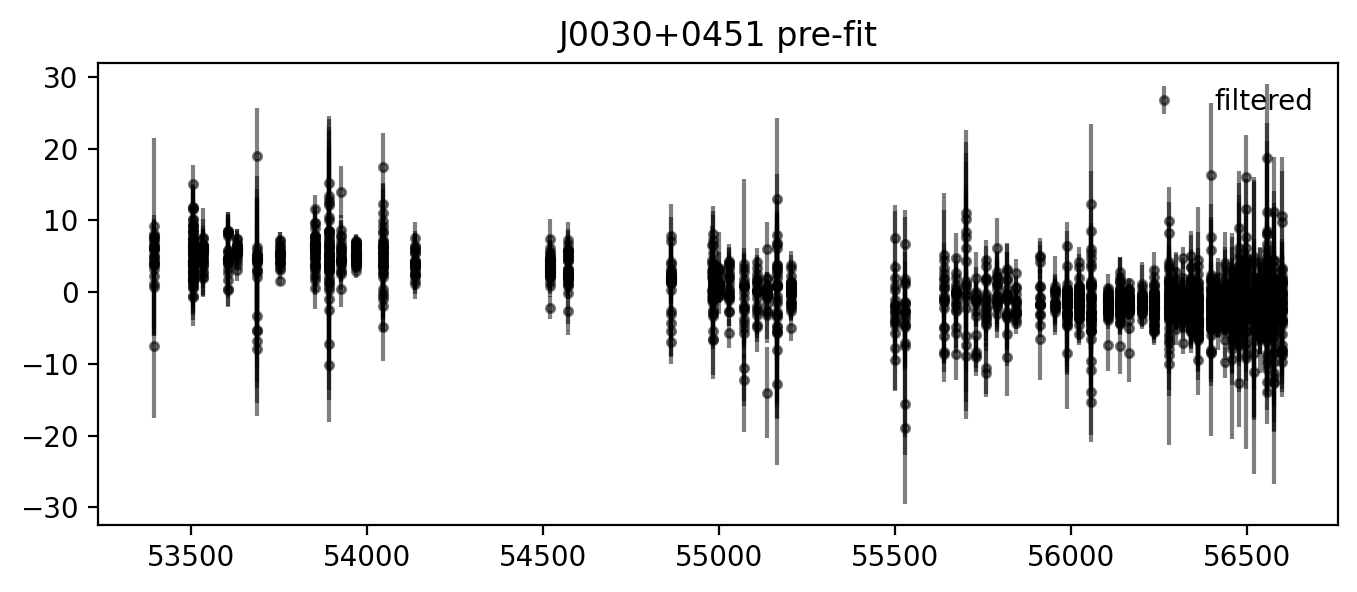

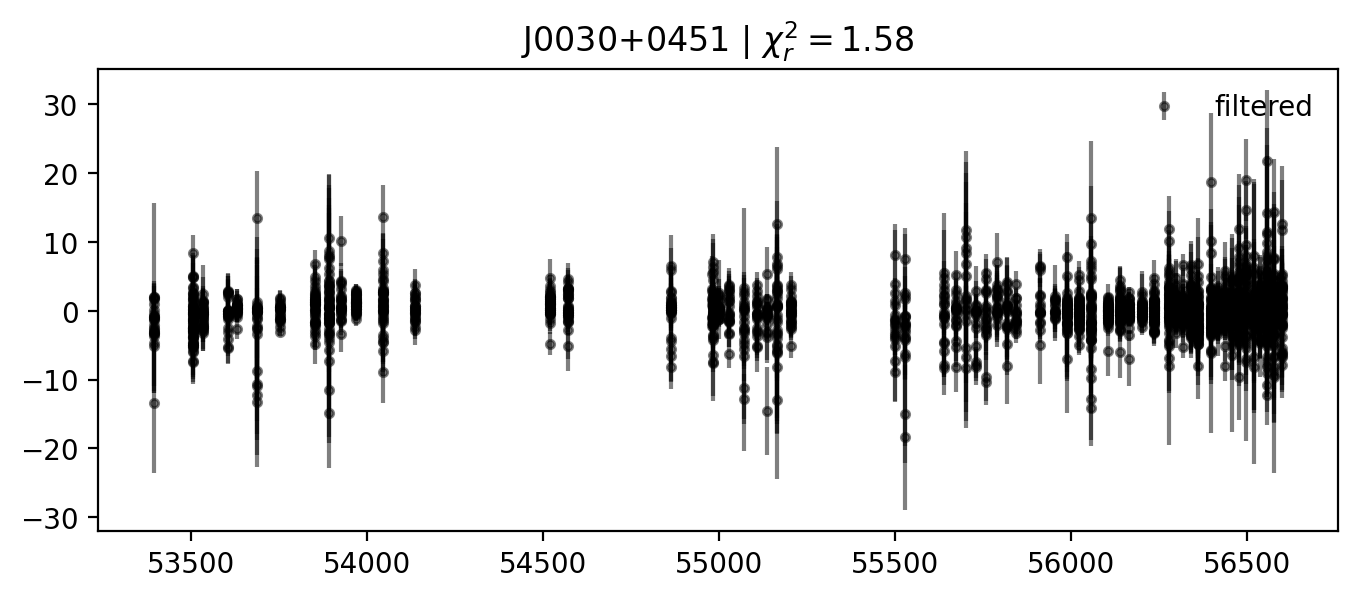

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 


Results for PSR J0030+0451


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 1.350 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = 0
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       0.132894341958959         0.132894349881047         1.2867e-09    7.9221e-09    Y
RAJ (hms)       00:30:27.4283797           00:30:27.4284886         1.7694e-05    0.00010894   
DECJ (rad)      0.0848409741264155        0.084840955947706         2.9347e-09    -1.8179e-08   Y
DECJ (dms)      +04:51:39.70709           +04:51:39.70334           0.00060532    -0.0037496   
F0 (s^-1)       205.530695938455          205.530695938461          1.084e-13

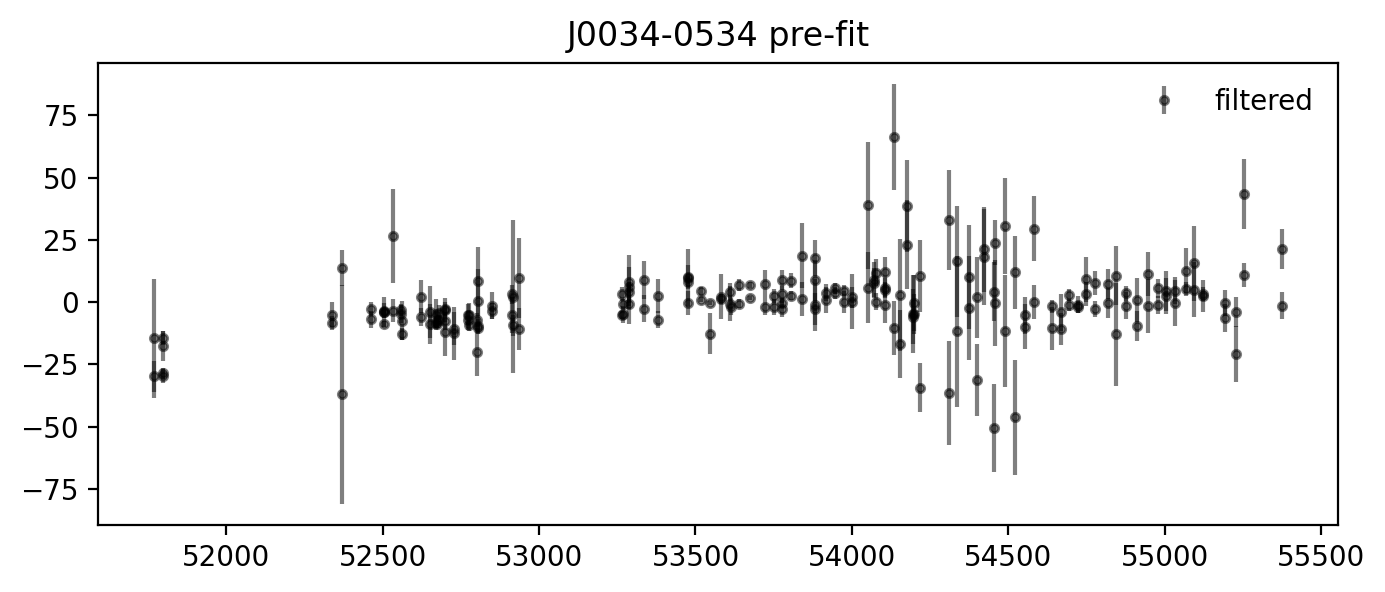

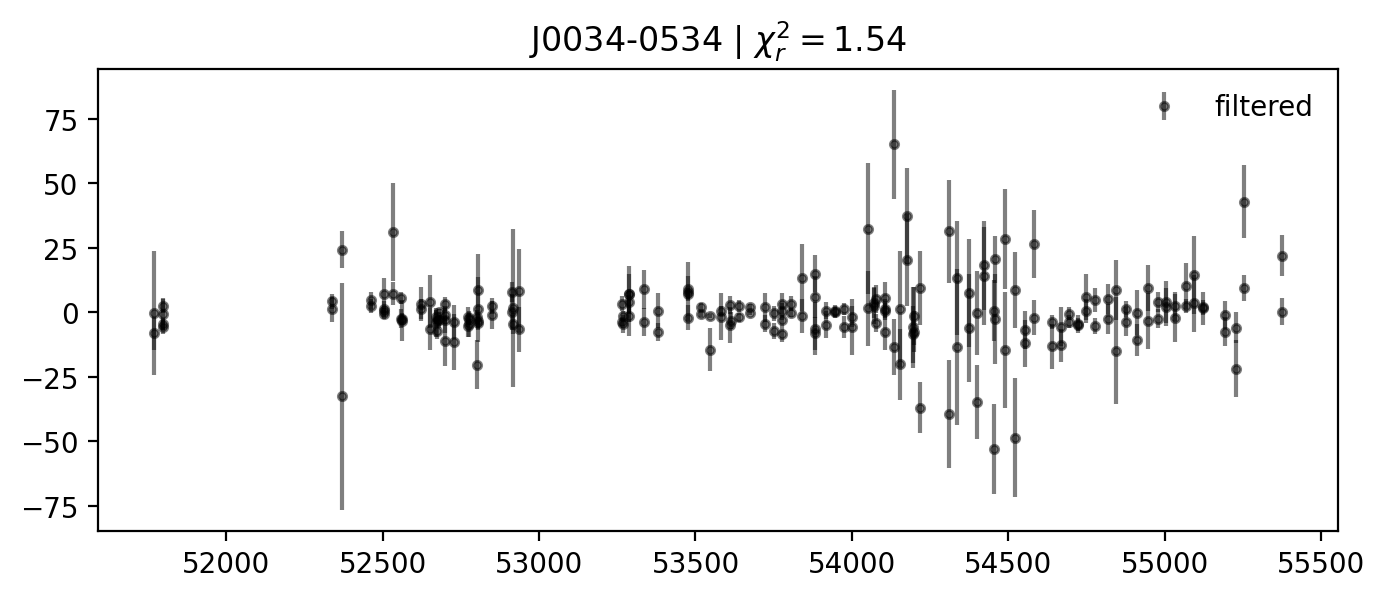

[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


Results for PSR J0034-0534


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 3.974 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = 0
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       0.149940816847108         0.149940819201695         4.6677e-09    2.3546e-09    Y
RAJ (hms)       00:34:21.8342357           00:34:21.8342681         6.4186e-05    3.2378e-05   
DECJ (rad)      -0.0973346961378809       -0.0973347039371061       1.1111e-08    -7.7992e-09   Y
DECJ (dms)      -05:34:36.72224           -05:34:36.72385           0.0022919     -0.0016087   
F0 (s^-1)       532.713429395218          532.713429395305          5.6992e-11    

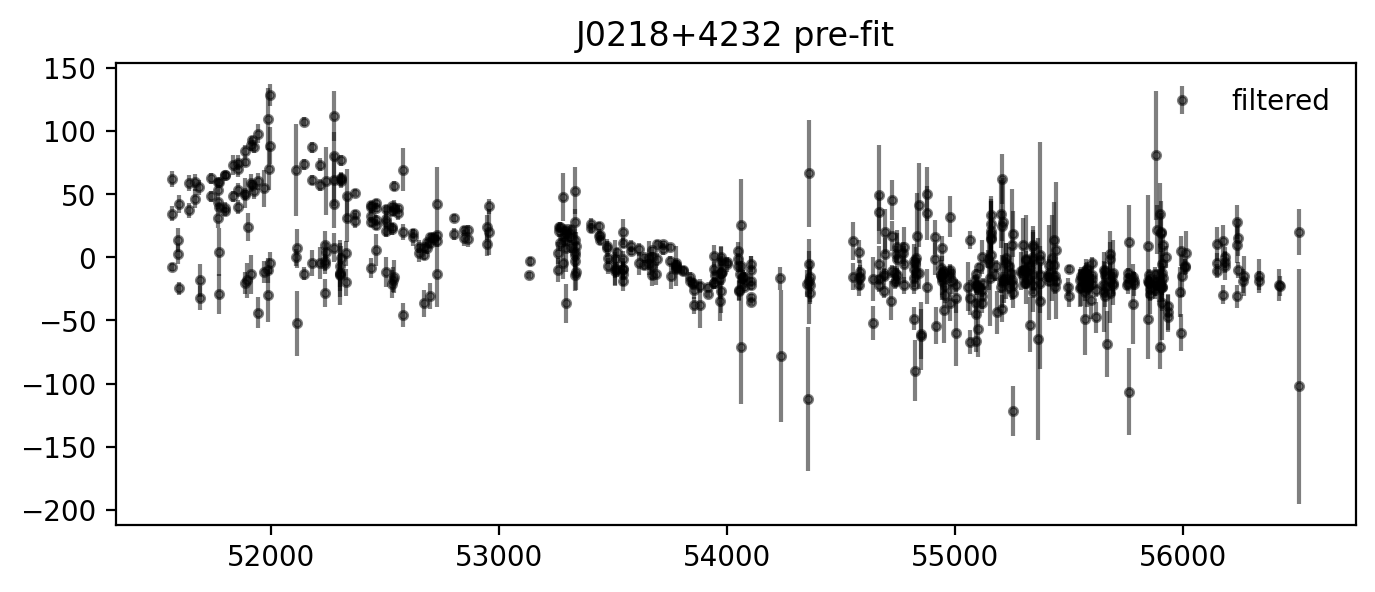

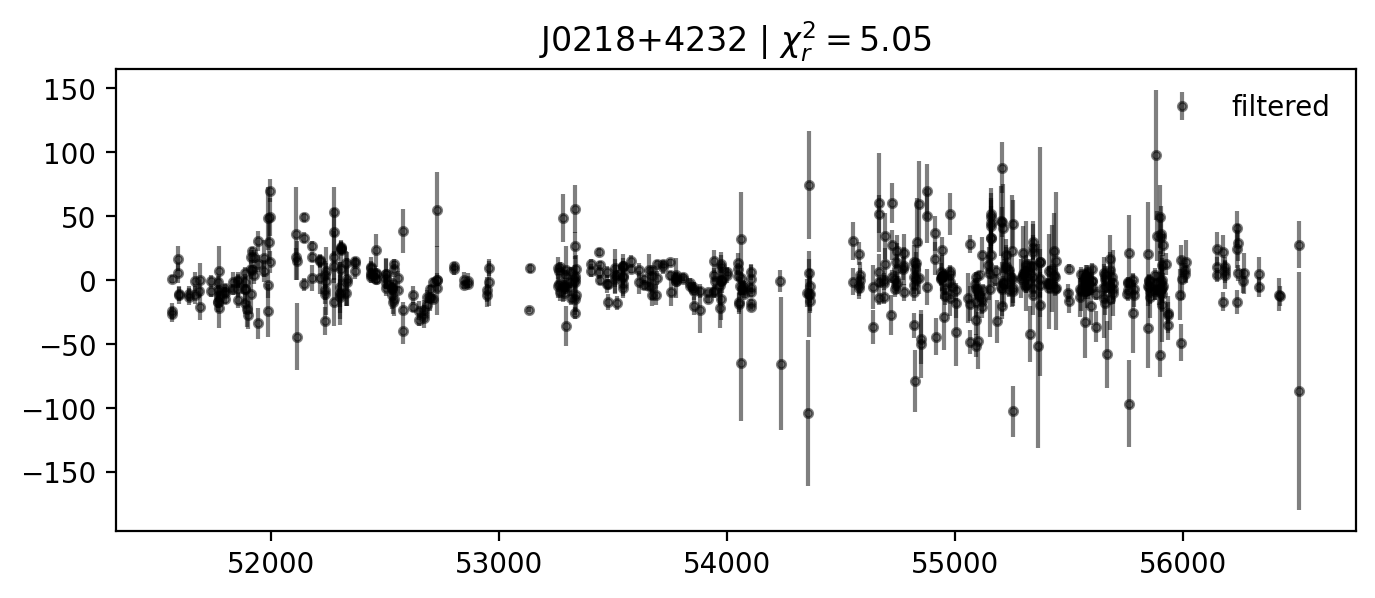

[observatory.C:272] Warning: Assuming site 'g' means 'eff'


Results for PSR J0218+4232


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 12.370 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = 0
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       0.602600908342063         0.602600908577281         1.6306e-09    2.3522e-10    Y
RAJ (hms)       02:18:06.3573069           02:18:06.3573101         2.2422e-05    3.2345e-06   
DECJ (rad)      0.742430979362267         0.742430985207272         1.9743e-09    5.845e-09     Y
DECJ (dms)      +42:32:17.38211           +42:32:17.38332           0.00040723    0.0012056    
F0 (s^-1)       430.461054545746          430.461054545748          4.7379e-12    2.2737e-12    Y
F

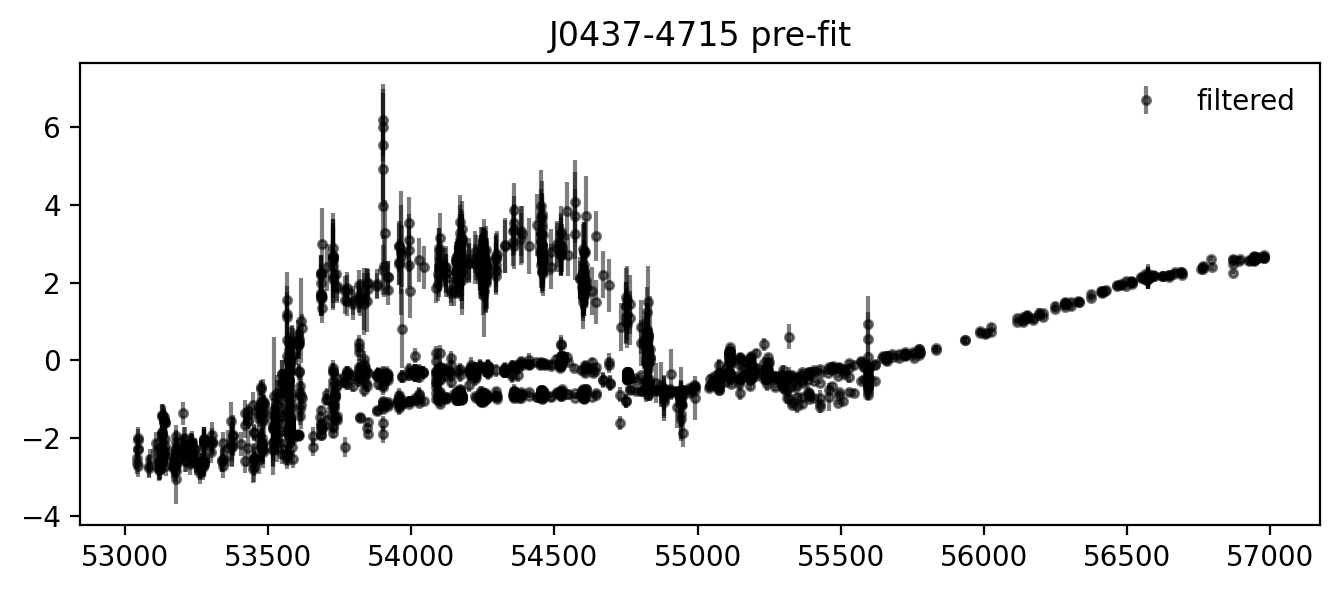

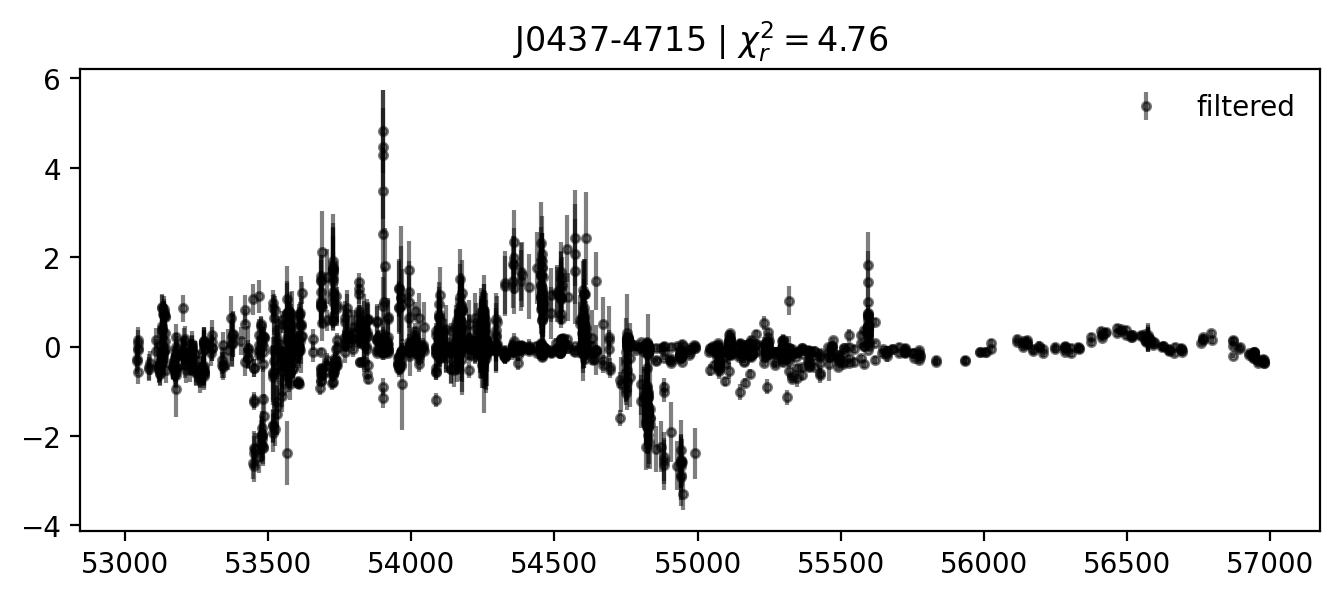



Results for PSR J0437-4715


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.177 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = 0
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       1.209797699061            1.20979769909984          9.0755e-12    3.8837e-11    Y
RAJ (hms)       04:37:15.9125330           04:37:15.9125335         1.248e-07     5.3405e-07   
DECJ (rad)      -0.824712716119959        -0.82471271633849         6.4033e-12    -2.1853e-10   Y
DECJ (dms)      -47:15:09.20860           -47:15:09.20865           1.3208e-06    -4.5075e-05  
F0 (s^-1)       173.68794573752           173.687945737518          3.8487e-14    -2.6148e-12   Y
F1 (s^-2)       -1.72834960472643e-15     -1.72837017900341e-

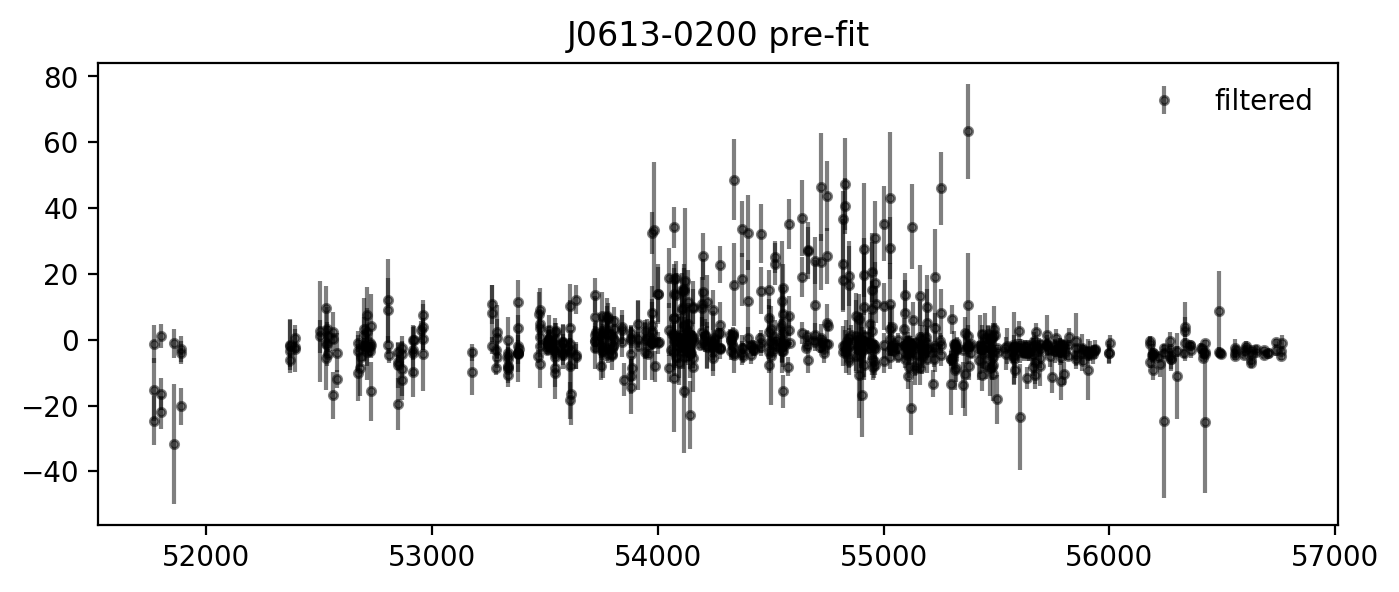

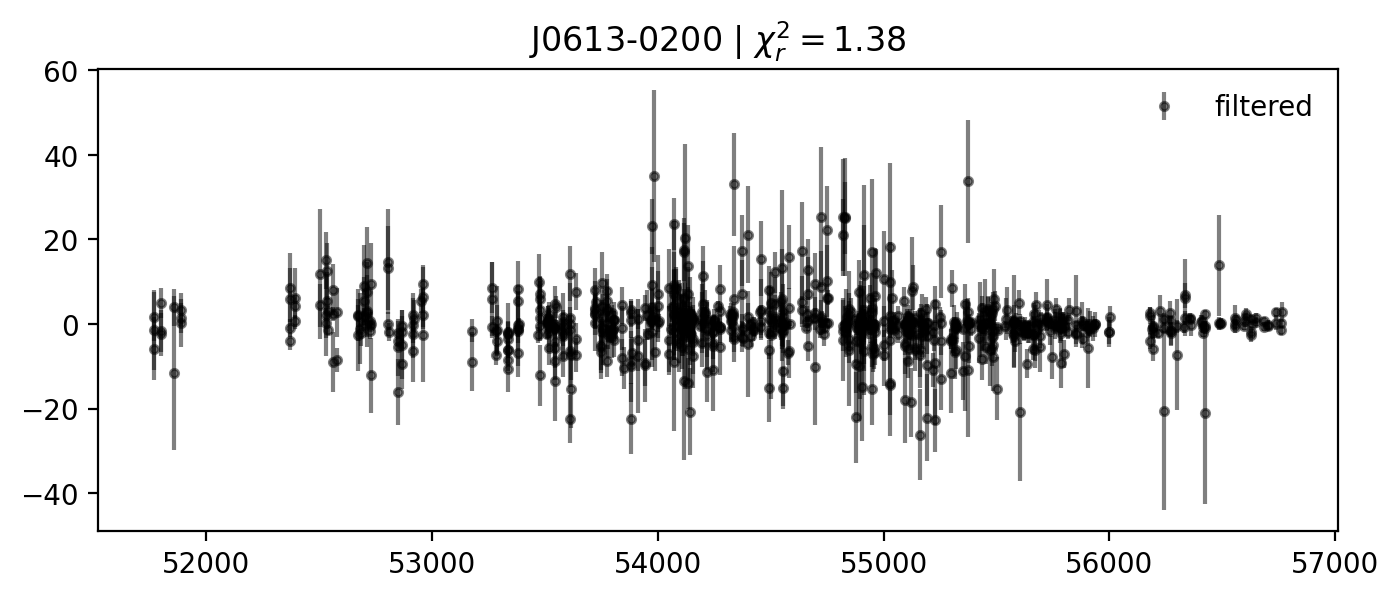



Results for PSR J0613-0200


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 1.984 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = 0
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       1.63071753048872          1.63071753007124          1.7348e-10    -4.1748e-10   Y
RAJ (hms)       06:13:43.9756980           06:13:43.9756923         2.3856e-06    -5.7408e-06  
DECJ (rad)      -0.0351355405794149       -0.0351355404946186       4.6207e-10    8.4796e-11    Y
DECJ (dms)      -02:00:47.22547           -02:00:47.22545           9.5308e-05    1.749e-05    
F0 (s^-1)       326.600562023488          326.600562023492          7.7083e-13    3.9222e-12    Y
F1 (s^-2)       -1.02296253060979e-15     -1.02292163677502e-

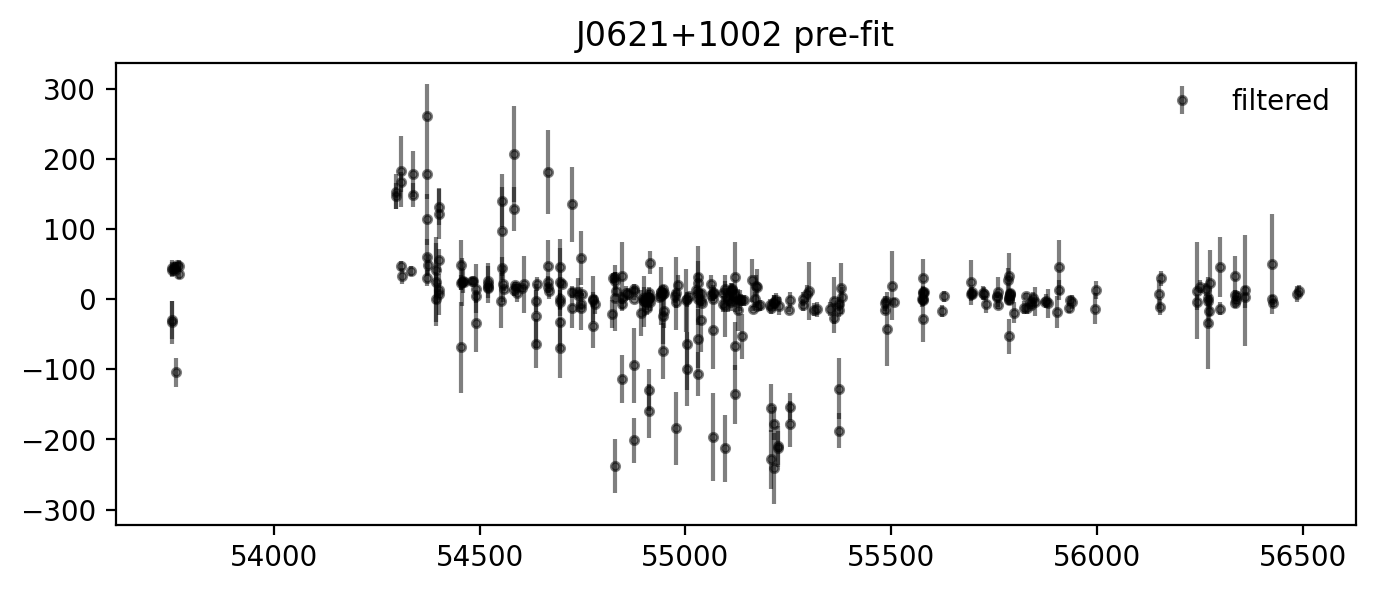

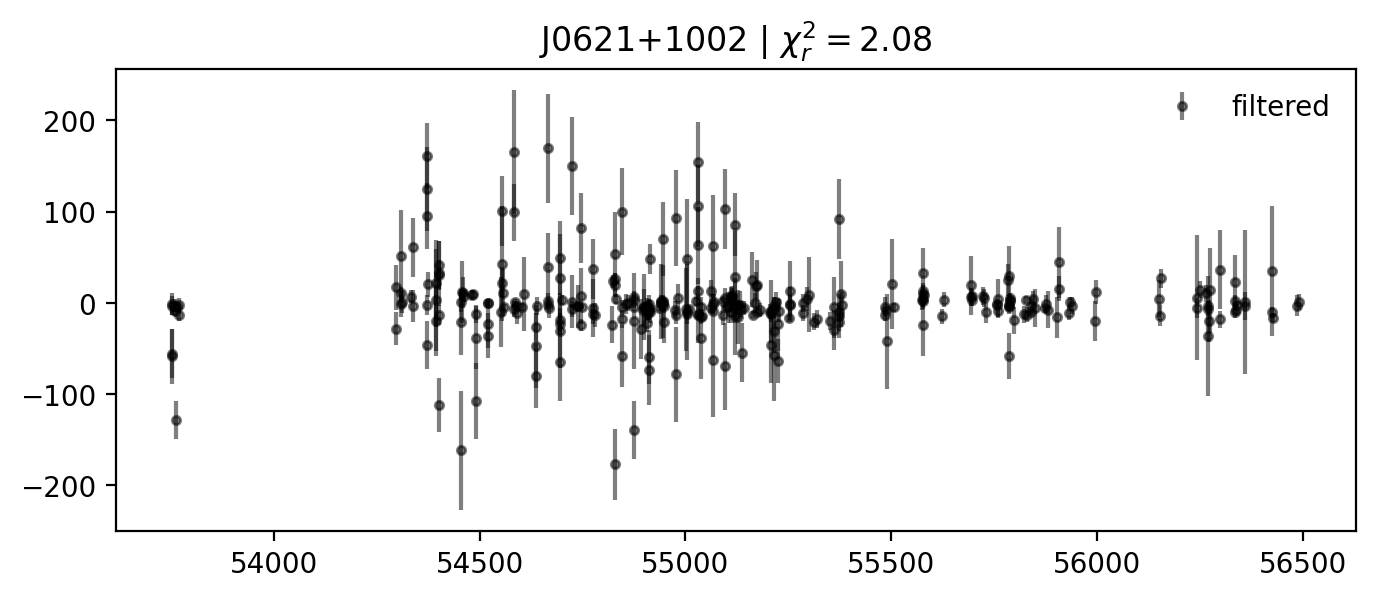



Results for PSR J0621+1002


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 9.774 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = 0
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       1.66403431546787          1.66403431870888          1.2411e-09    3.241e-09     Y
RAJ (hms)       06:21:22.1143779           06:21:22.1144225         1.7066e-05    4.4567e-05   
DECJ (rad)      0.175302491093335         0.175302526708026         6.0744e-09    3.5615e-08    Y
DECJ (dms)      +10:02:38.73436           +10:02:38.74171           0.0012529     0.0073461    
F0 (s^-1)       34.6574066214091          34.65740662141            1.7623e-12    8.3134e-13    Y
F1 (s^-2)       -5.68257139882257e-17     -5.6918117084542e-1

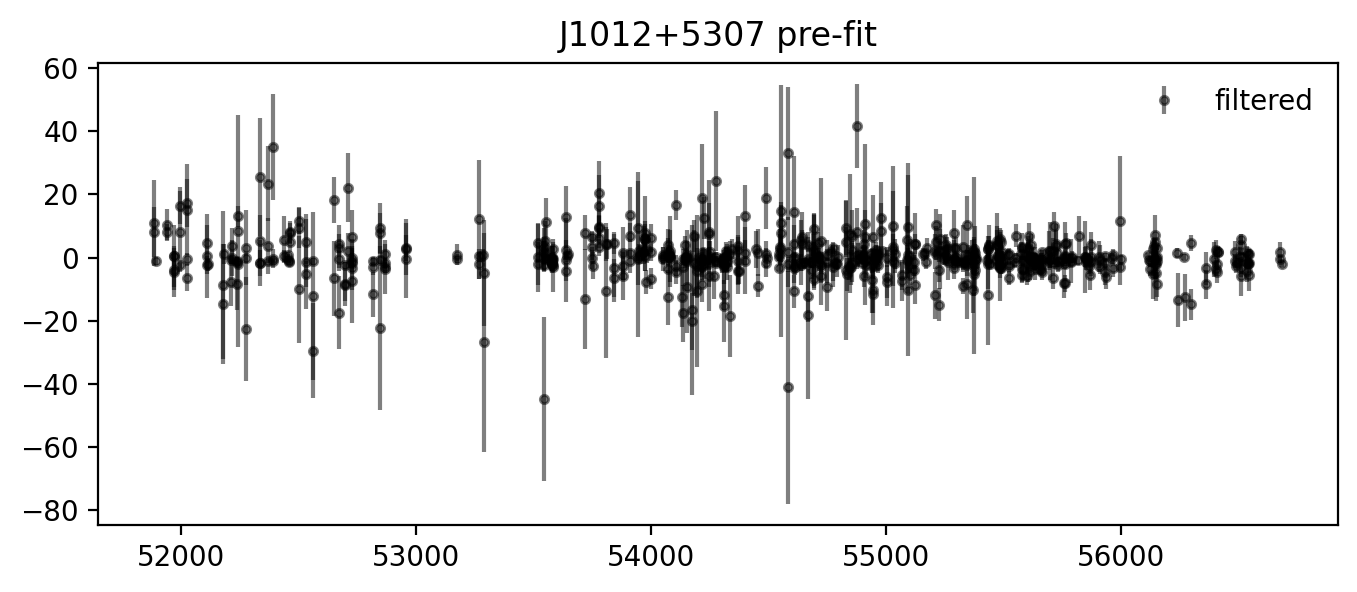

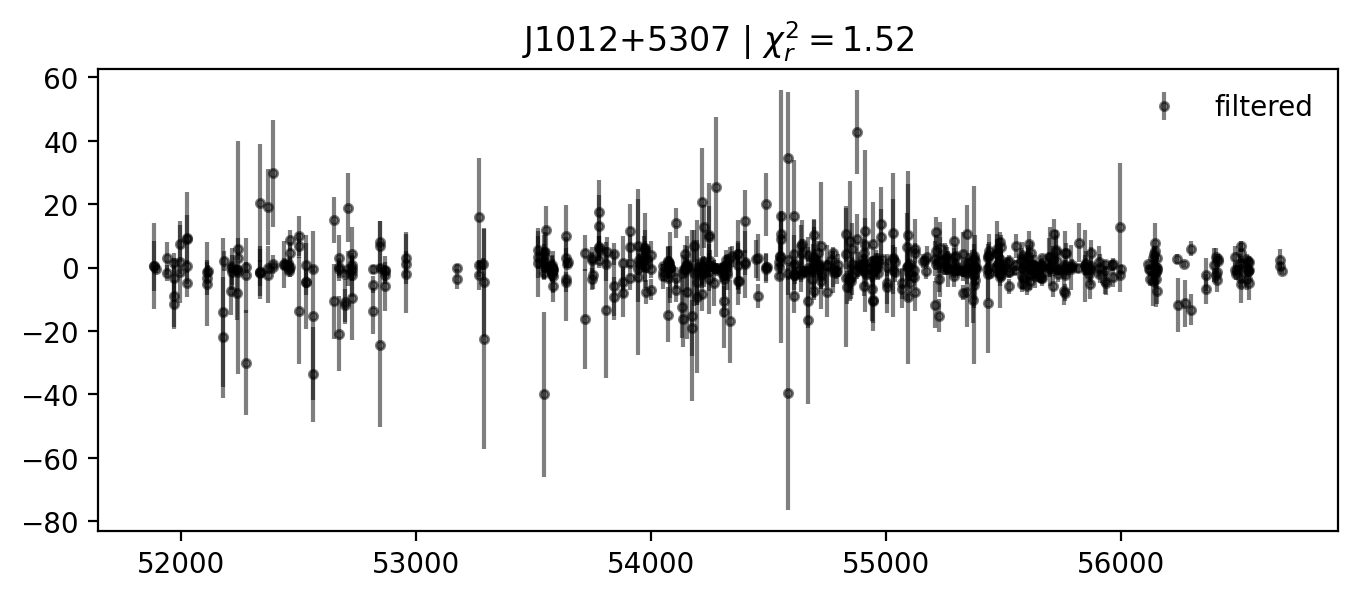



Results for PSR J1012+5307


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 1.689 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = 0
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       2.67278540137412          2.67278540138423          3.6825e-10    1.0113e-11    Y
RAJ (hms)       10:12:33.4375303           10:12:33.4375304         5.0638e-06    1.3906e-07   
DECJ (rad)      0.927071872653466         0.927071872732486         2.3659e-10    7.902e-11     Y
DECJ (dms)      +53:07:02.30019           +53:07:02.30021           4.88e-05      1.6299e-05   
F0 (s^-1)       190.267834441554          190.267834441555          4.3273e-13    1.1937e-12    Y
F1 (s^-2)       -6.20044583814284e-16     -6.20032838274993e-

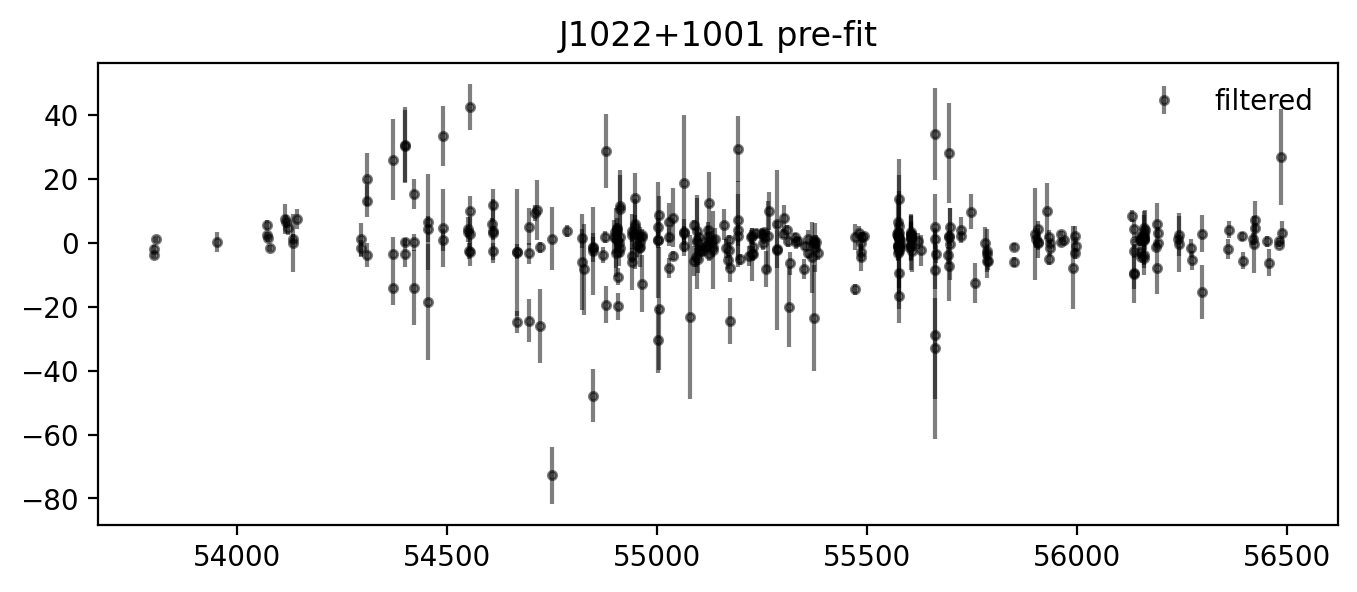

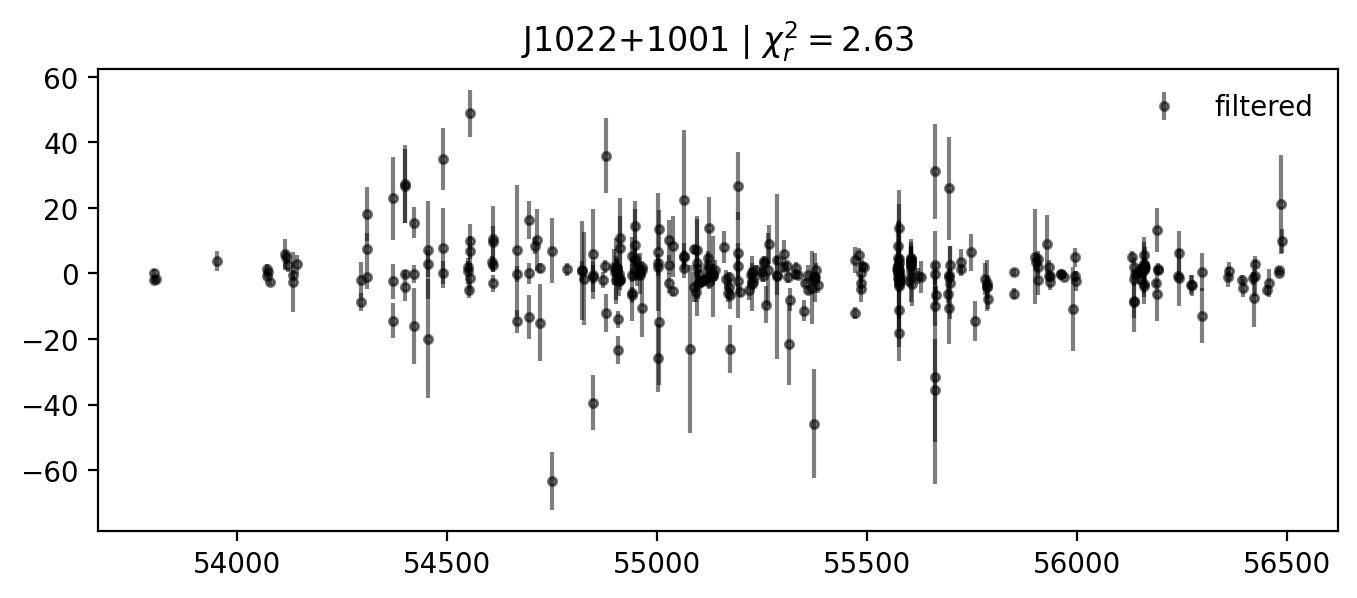



Results for PSR J1022+1001


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 2.986 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = 0
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
ELONG           153.865866930313          153.865866916745          2.5634e-08    -1.3568e-08   Y
ELAT            -0.0638937216937713       -0.0639964368368939       2.6112e-05    -0.00010272   Y
F0 (s^-1)       60.7794479566968          60.7794479566981          3.3525e-13    1.3145e-12    Y
F1 (s^-2)       -1.60093902733362e-16     -1.60039381894108e-16     8.8542e-21    5.4521e-20    Y
PEPOCH (MJD)    55000                     55000                     0             0             N
POSEPOCH (MJD)  55000                     55000          

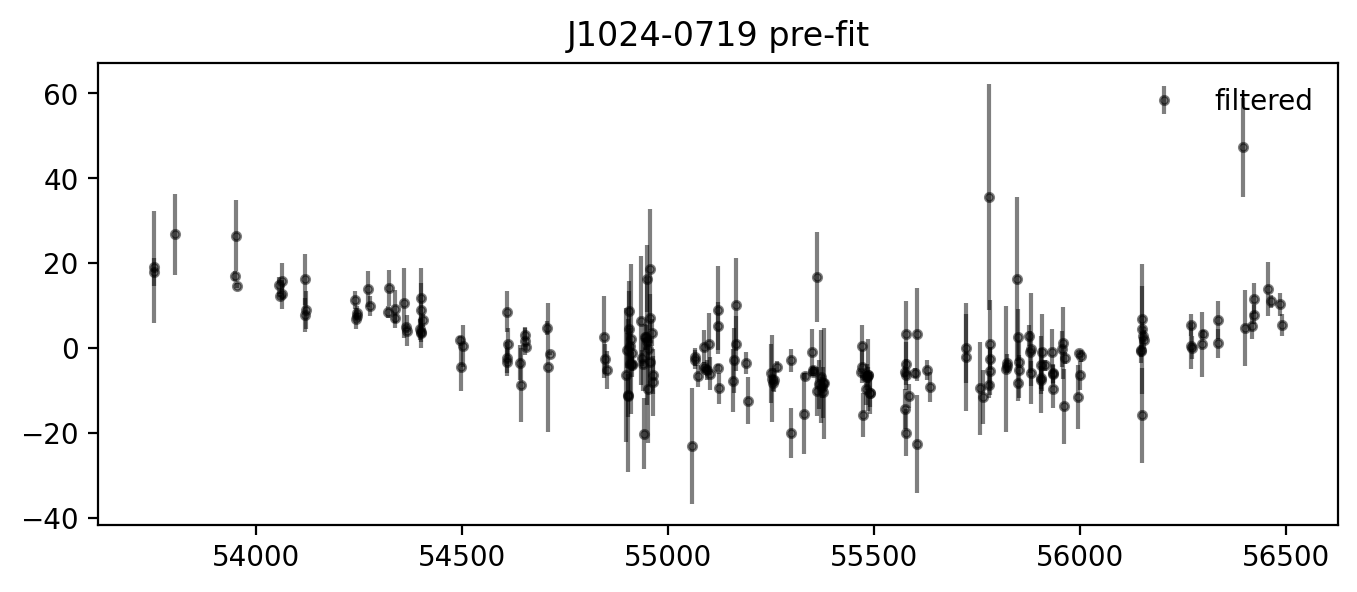

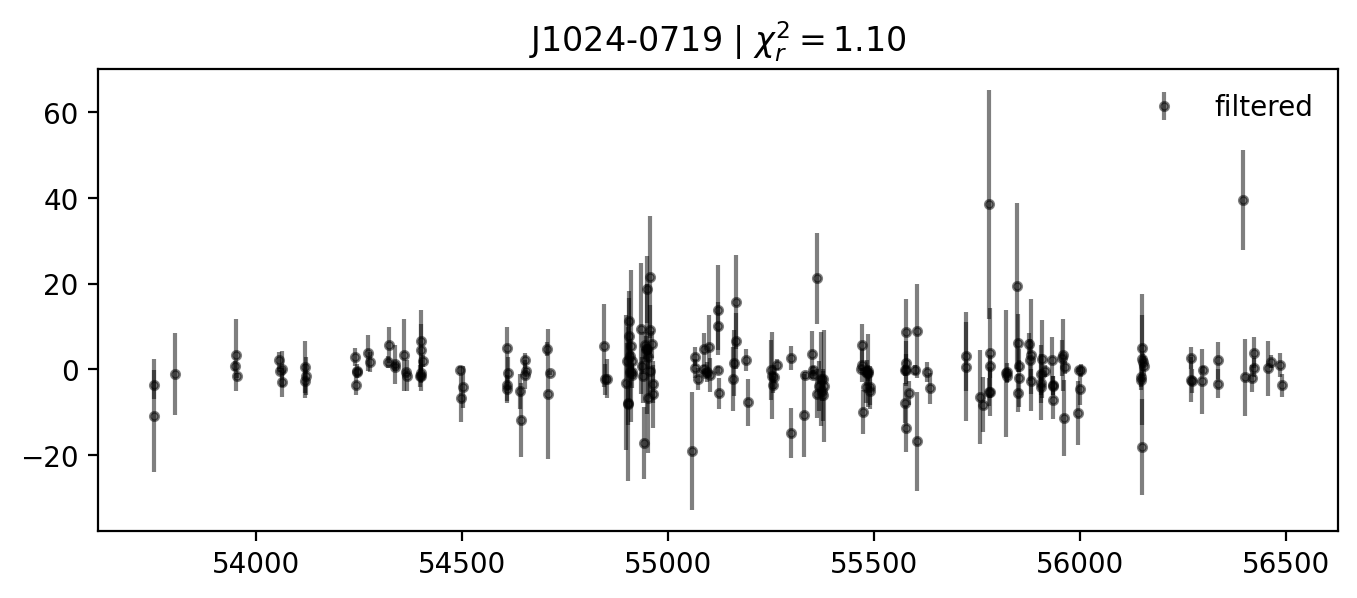



Results for PSR J1024-0719


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 1.699 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = 0
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       2.72552618764751          2.72552618761573          7.9867e-10    -3.1777e-11   Y
RAJ (hms)       10:24:38.6754011           10:24:38.6754007         1.0983e-05    -4.3697e-07  
DECJ (rad)      -0.127794141083004        -0.127794138050727        1.7255e-09    3.0323e-09    Y
DECJ (dms)      -07:19:19.43375           -07:19:19.43312           0.00035591    0.00062545   
F0 (s^-1)       193.715683448525          193.715683448553          4.4238e-12    2.7484e-11    Y
F1 (s^-2)       -6.95440065176227e-16     -6.96180353495702e-

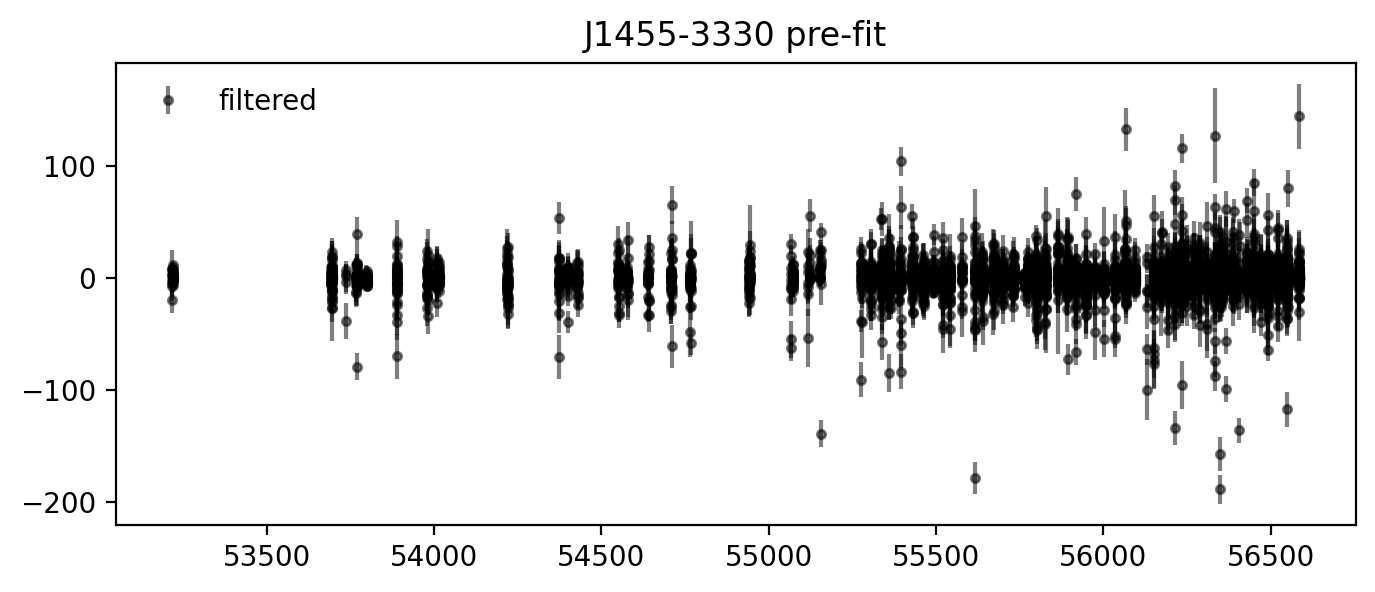

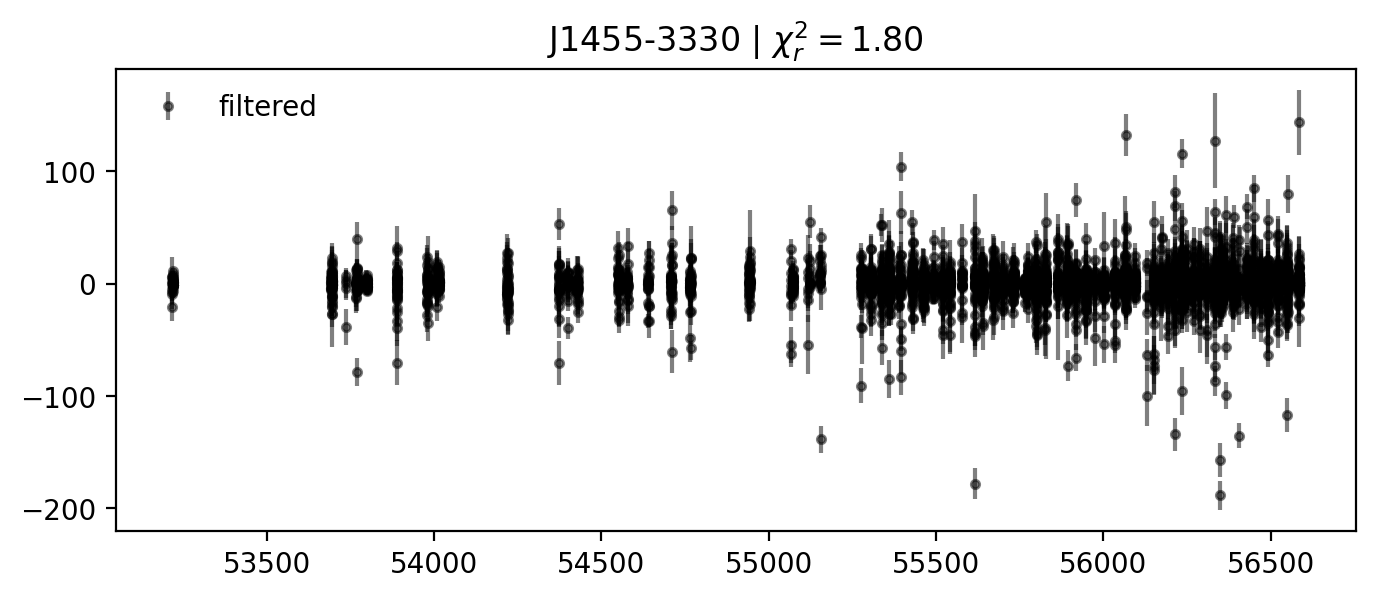



Results for PSR J1455-3330


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 4.331 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = 0
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       3.90866266852952          3.90866266835618          5.6754e-10    -1.7334e-10   Y
RAJ (hms)       14:55:47.9698673           14:55:47.9698649         7.8043e-06    -2.3836e-06  
DECJ (rad)      -0.584910157894172        -0.584910157116589        1.1014e-09    7.7758e-10    Y
DECJ (dms)      -33:30:46.38039           -33:30:46.38023           0.00022719    0.00016039   
F0 (s^-1)       125.200243244995          125.200243244995          3.0199e-13    -6.1107e-13   Y
F1 (s^-2)       -3.80952653792189e-16     -3.80940889008332e-

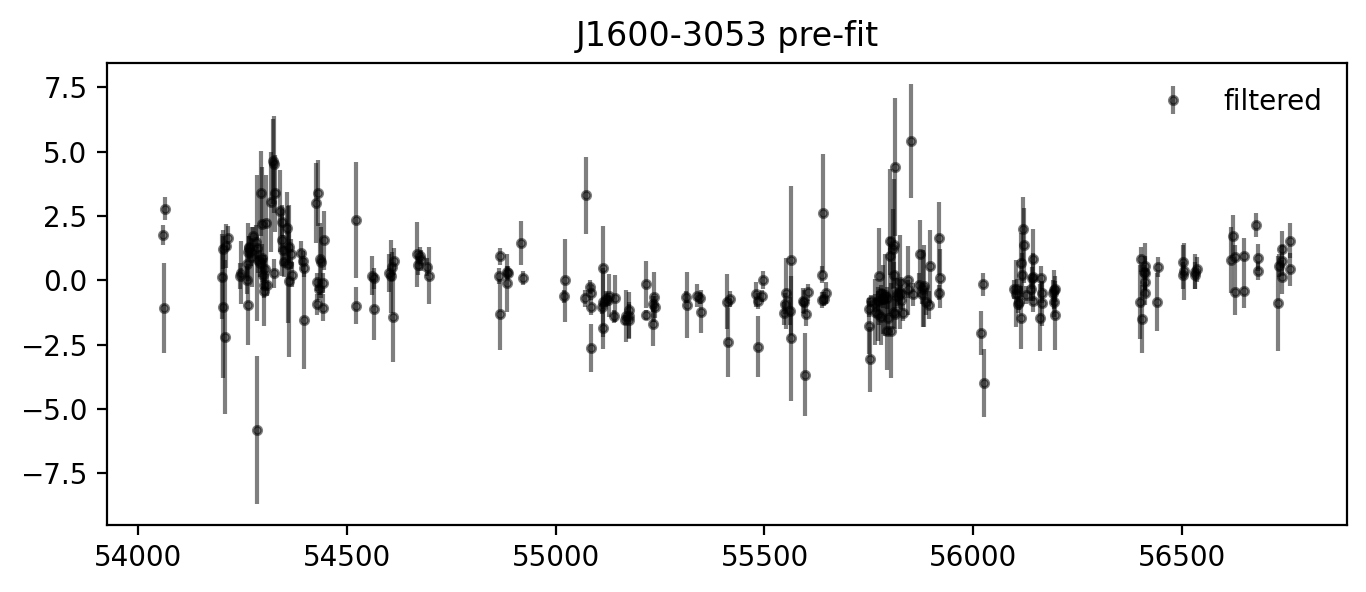

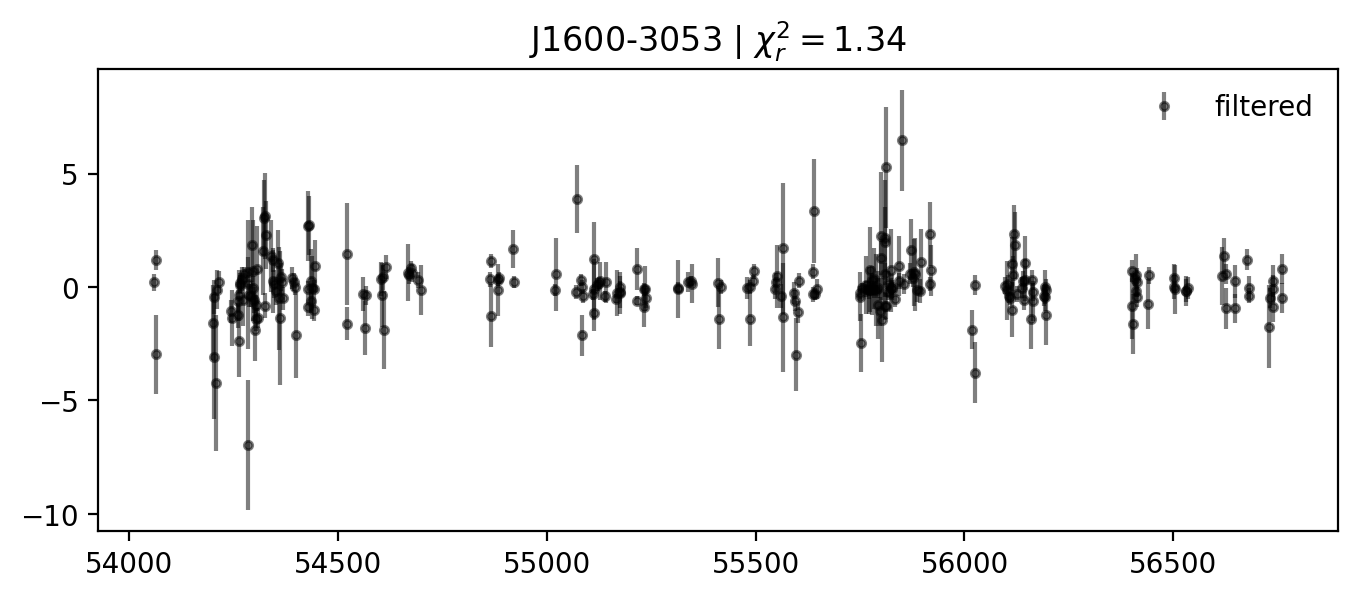



Results for PSR J1600-3053


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.569 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = 0
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       4.19256472329813          4.19256472321729          2.0211e-10    -8.0836e-11   Y
RAJ (hms)       16:00:51.9033553           16:00:51.9033542         2.7793e-06    -1.1116e-06  
DECJ (rad)      -0.539255228042888        -0.539255229310896        6.2301e-10    -1.268e-09    Y
DECJ (dms)      -30:53:49.37513           -30:53:49.37539           0.00012851    -0.00026155  
F0 (s^-1)       277.937706989608          277.937706989616          2.1243e-12    7.9012e-12    Y
F1 (s^-2)       -7.33851506966951e-16     -7.33945488412916e-

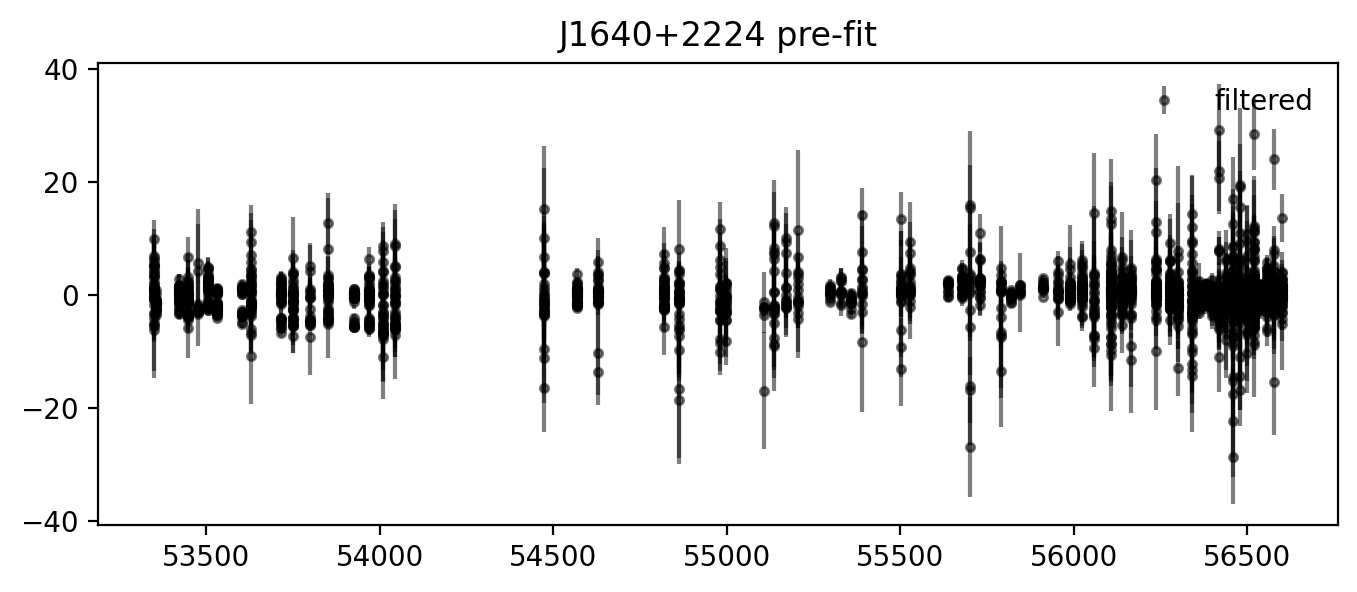

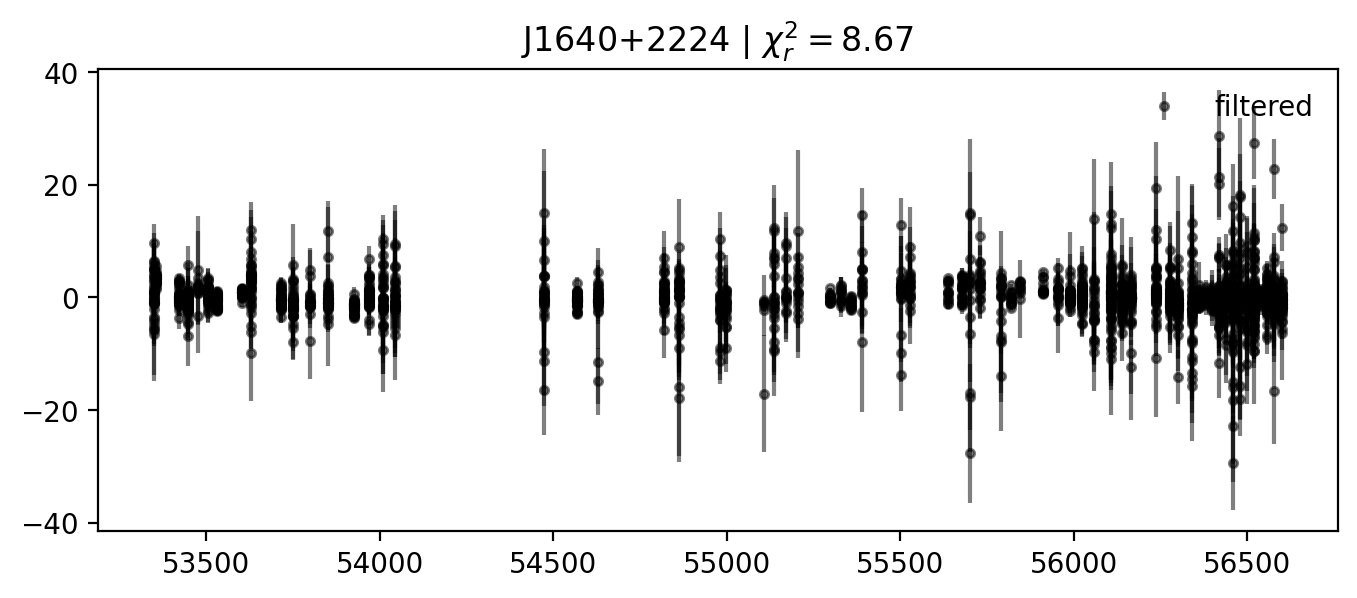



Results for PSR J1640+2224


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 1.299 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = 0
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       4.36454085007375          4.3645408508833           2.8511e-11    8.0955e-10    Y
RAJ (hms)       16:40:16.7448532           16:40:16.7448648         3.9205e-07    1.1132e-05   
DECJ (rad)      0.390996615503016         0.390996616698448         4.1947e-11    1.1954e-09    Y
DECJ (dms)      +22:24:08.84114           +22:24:08.84139           8.6522e-06    0.00024658   
F0 (s^-1)       316.123979331856          316.123979331855          1.26e-13      -9.6634e-13   Y
F1 (s^-2)       -2.81540932664572e-16     -2.8157598868449e-1

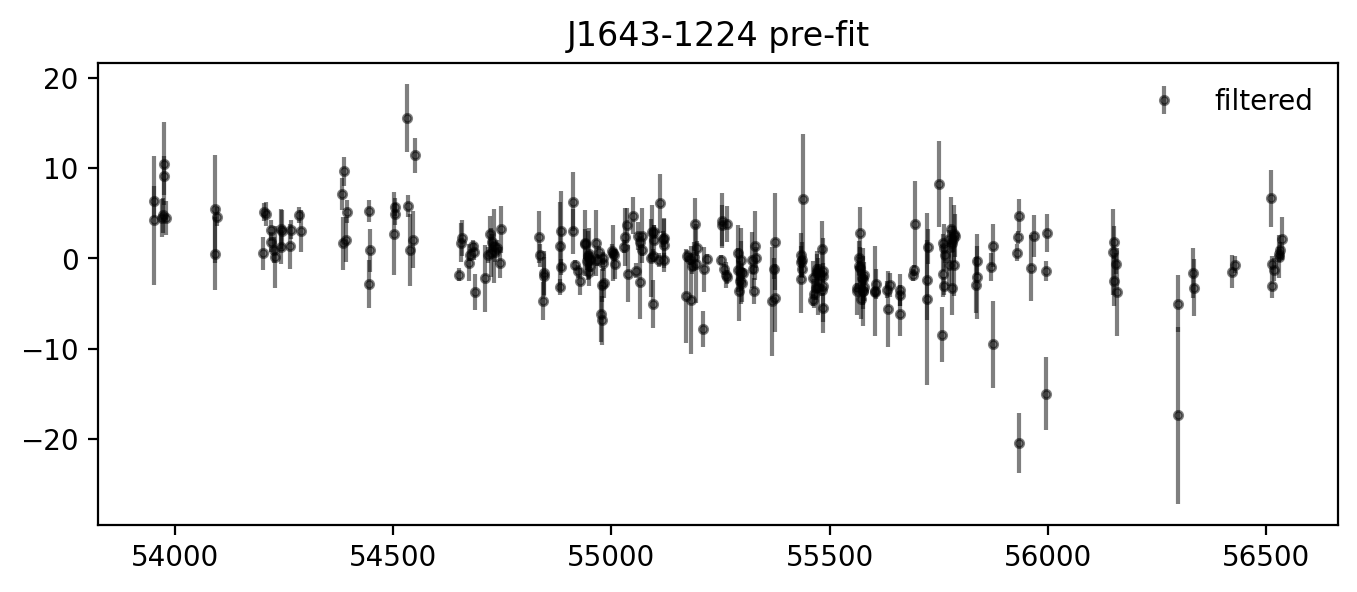

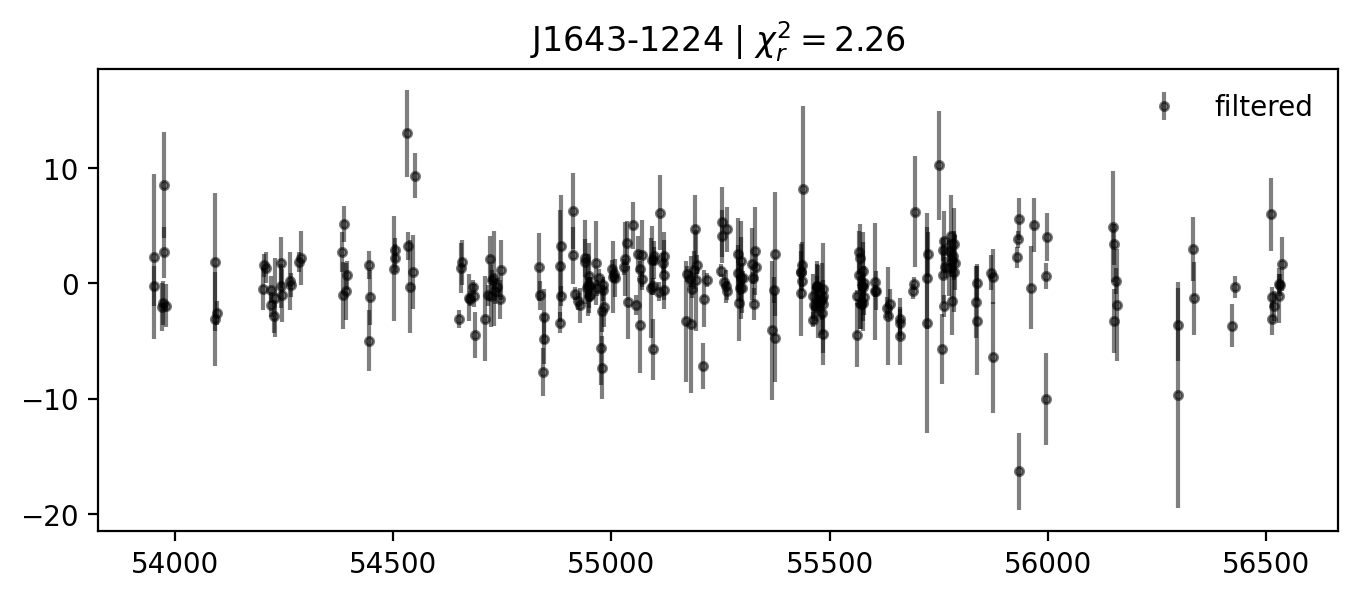



Results for PSR J1643-1224


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 1.832 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = 0
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       4.37918828508203          4.3791882837732           3.5889e-10    -1.3088e-09   Y
RAJ (hms)       16:43:38.1615428           16:43:38.1615248         4.935e-06     -1.7998e-05  
DECJ (rad)      -0.216705282560191        -0.216705286351058        1.7218e-09    -3.7909e-09   Y
DECJ (dms)      -12:24:58.67312           -12:24:58.67390           0.00035514    -0.00078192  
F0 (s^-1)       216.373337142635          216.373337142642          2.7849e-12    7.5602e-12    Y
F1 (s^-2)       -8.6439561089257e-16      -8.64249518764813e-

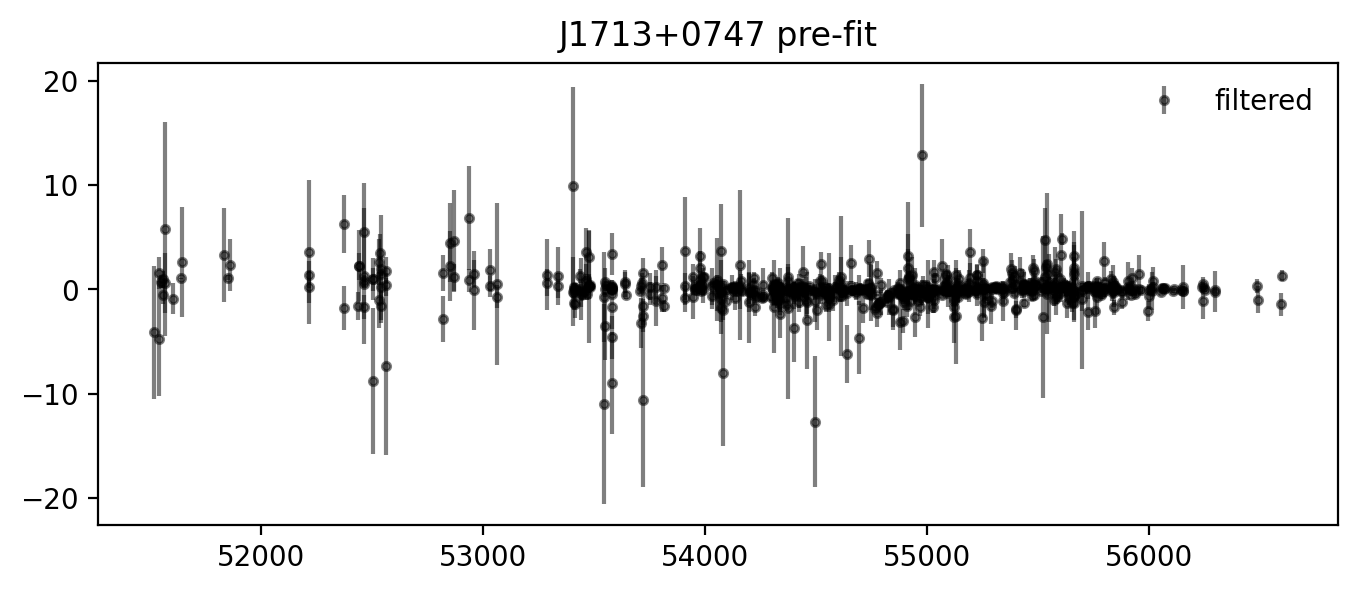

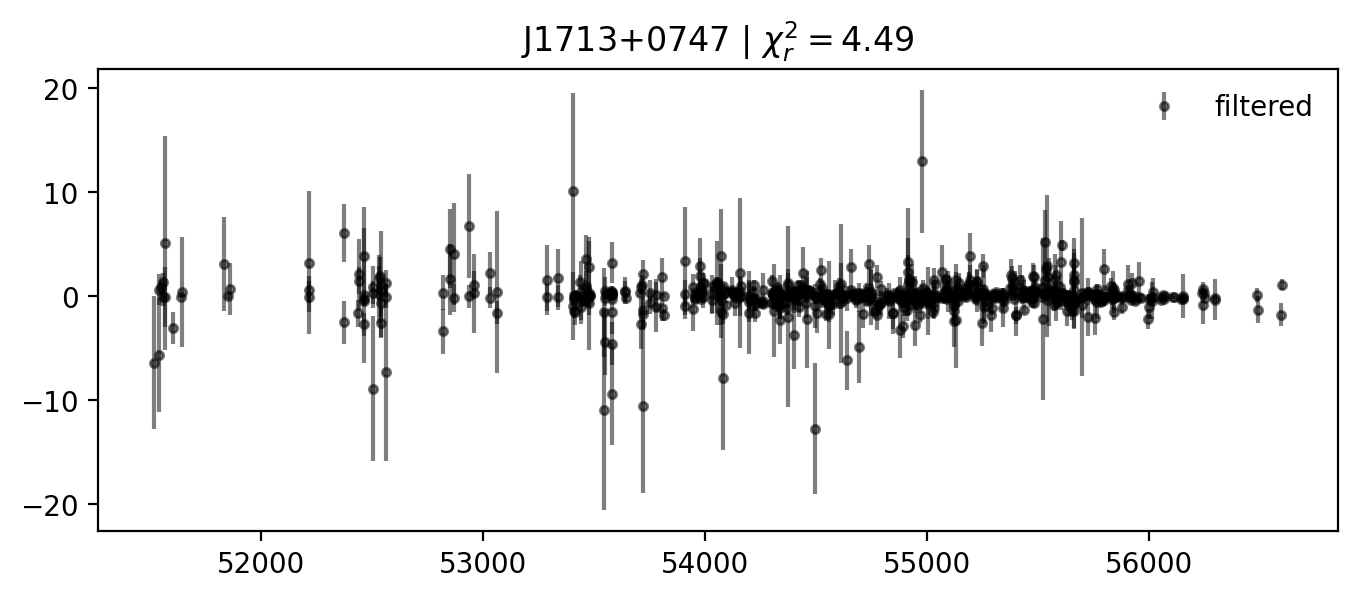



Results for PSR J1713+0747


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.302 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = 0
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       4.51091494893157          4.51091494903939          1.683e-11     1.0783e-10    Y
RAJ (hms)       17:13:49.5331959           17:13:49.5331974         2.3143e-07    1.4827e-06   
DECJ (rad)      0.13602656250717          0.136026563015047         3.7566e-11    5.0788e-10    Y
DECJ (dms)      +07:47:37.49256           +07:47:37.49266           7.7486e-06    0.00010476   
F0 (s^-1)       218.811840417158          218.811840417158          1.4747e-13    1.4211e-13    Y
F1 (s^-2)       -4.08386432520113e-16     -4.08389444418301e-

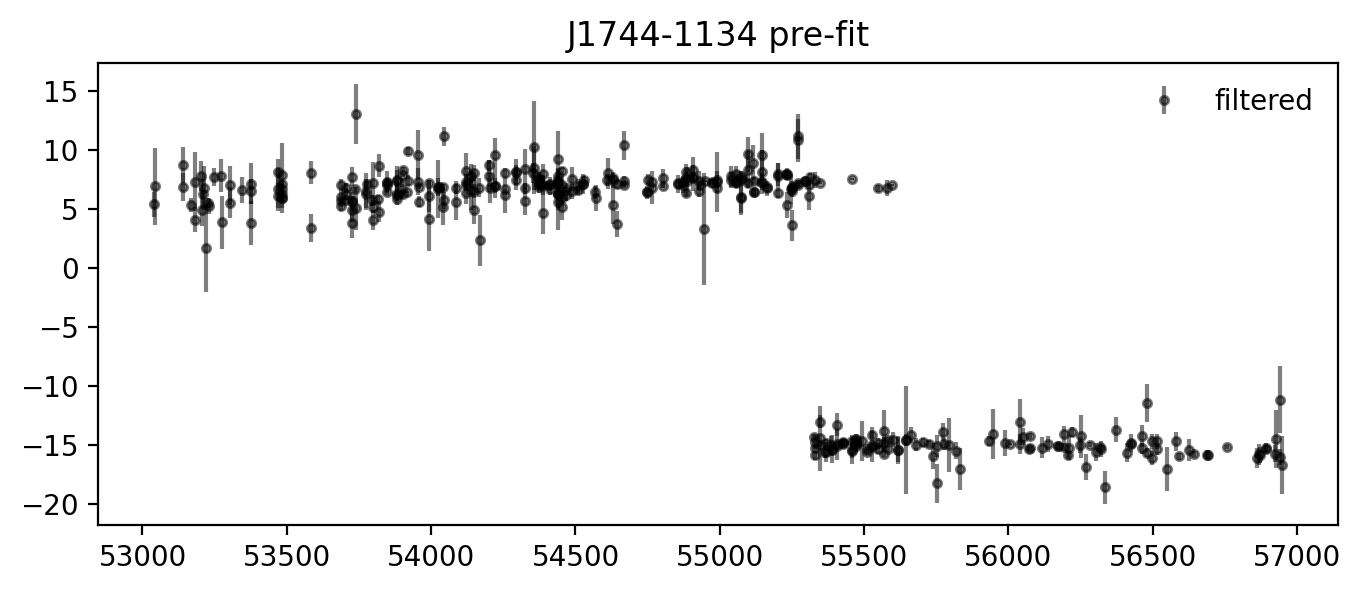

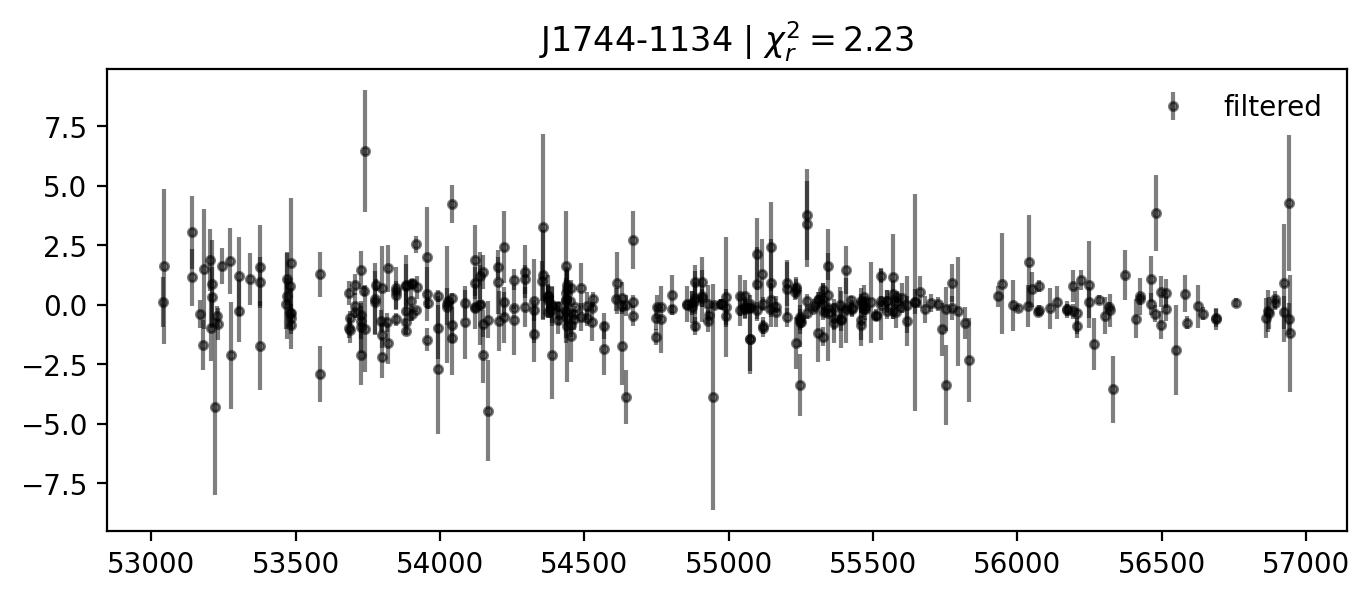



Results for PSR J1744-1134


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.364 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = 0
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       4.64471438801008          4.64471438796787          4.6482e-11    -4.221e-11    Y
RAJ (hms)       17:44:29.4075544           17:44:29.4075538         6.3917e-07    -5.8043e-07  
DECJ (rad)      -0.202141582117754        -0.202141581072856        2.4225e-10    1.0449e-09    Y
DECJ (dms)      -11:34:54.69427           -11:34:54.69405           4.9968e-05    0.00021553   
F0 (s^-1)       245.426119689809          245.426119689808          3.3636e-13    -8.8107e-13   Y
F1 (s^-2)       -5.38164425731955e-16     -5.38149645069165e-

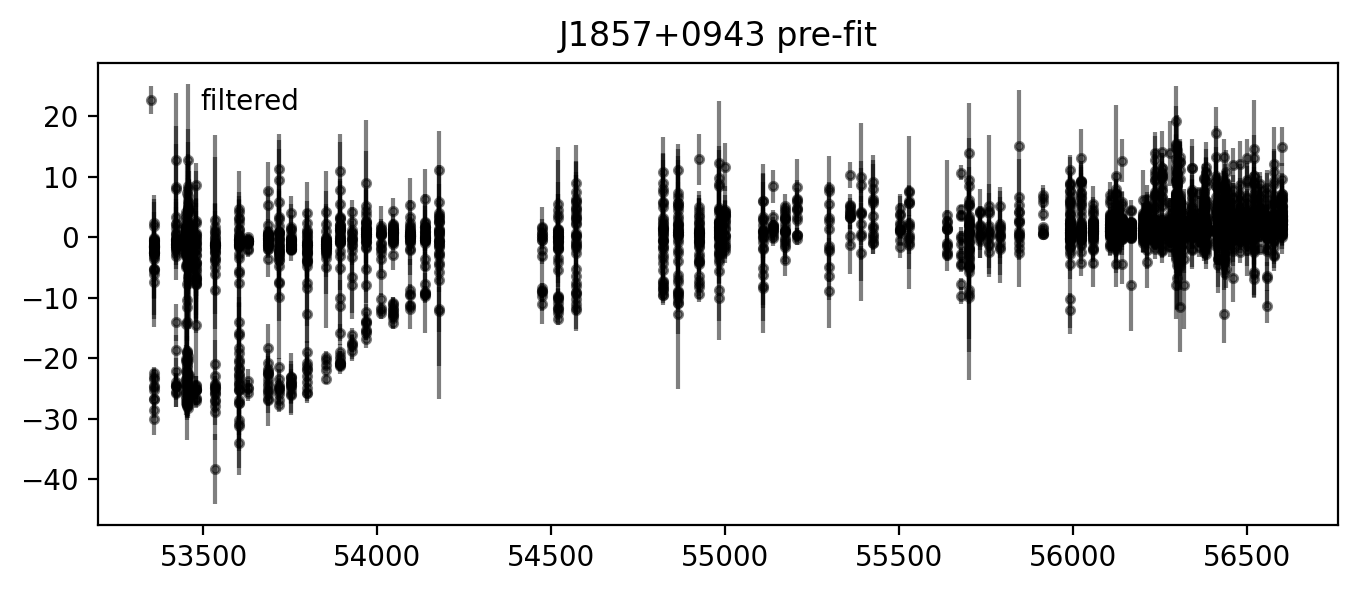

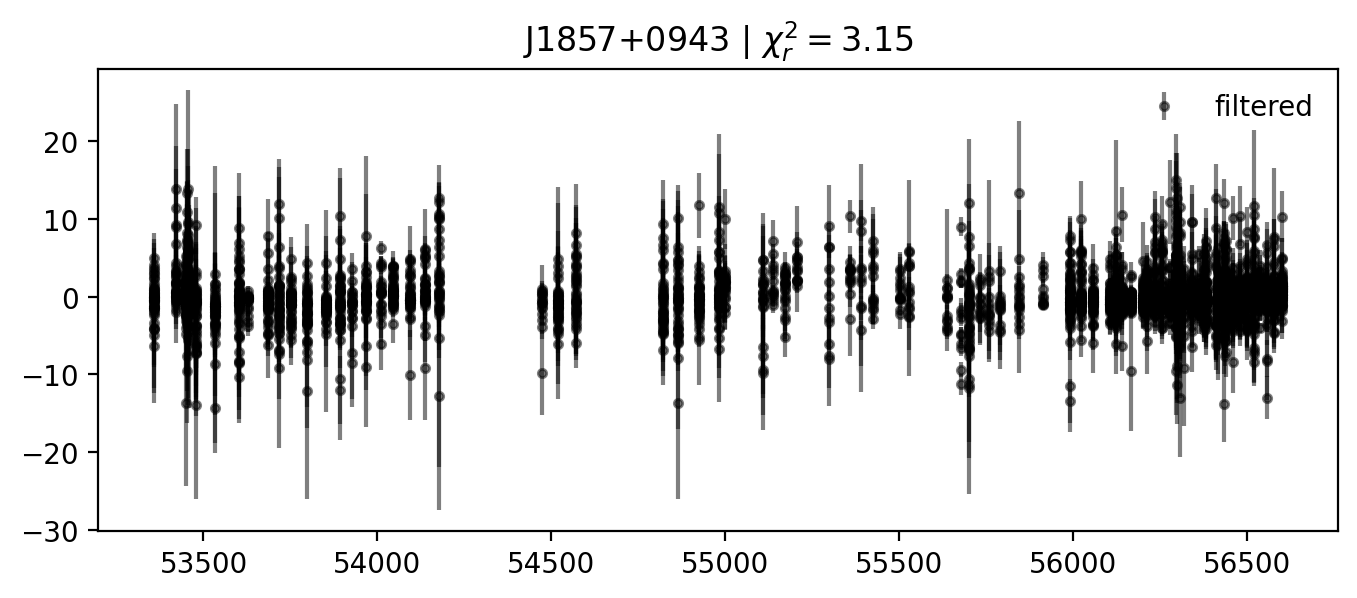



Results for PSR J1857+0943


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.913 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = 0
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       4.96374479949079          4.96374479927539          3.4252e-11    -2.154e-10    Y
RAJ (hms)       18:57:36.3906218           18:57:36.3906188         4.71e-07      -2.9619e-06  
DECJ (rad)      0.169671248124001         0.16967124896042          8.2696e-11    8.3642e-10    Y
DECJ (dms)      +09:43:17.20712           +09:43:17.20729           1.7057e-05    0.00017252   
F0 (s^-1)       186.494078377978          186.494078377979          3.0166e-14    5.1159e-13    Y
F1 (s^-2)       -6.2044603126106e-16      -6.20445823124213e-

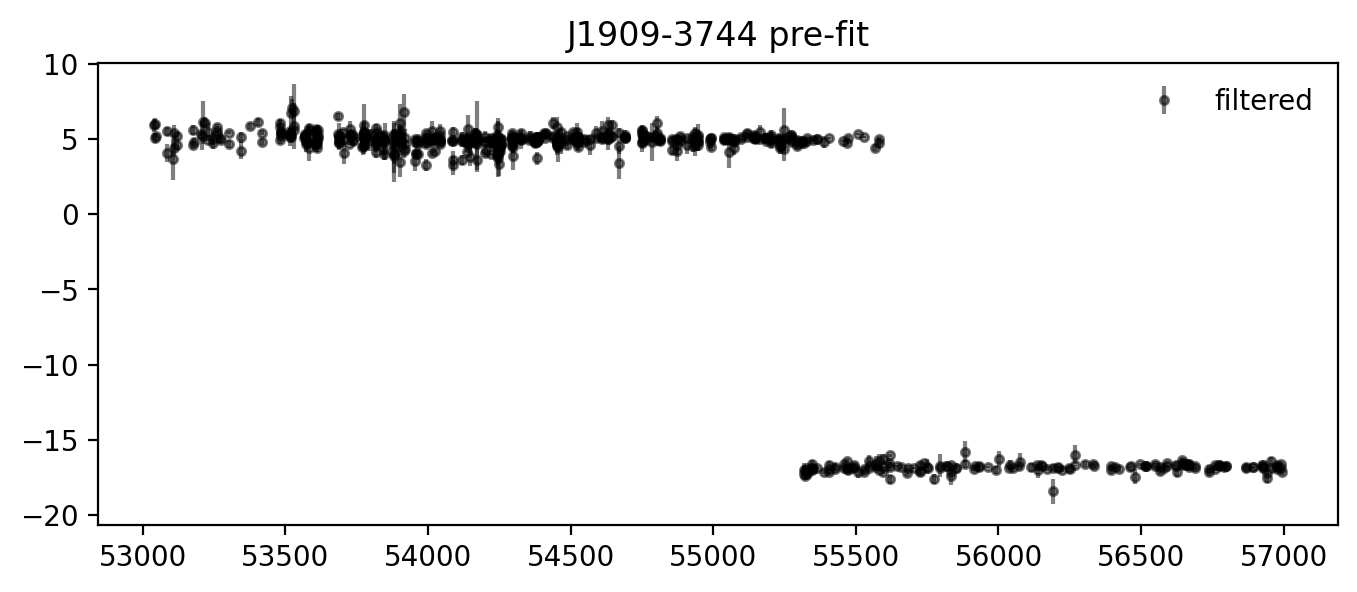

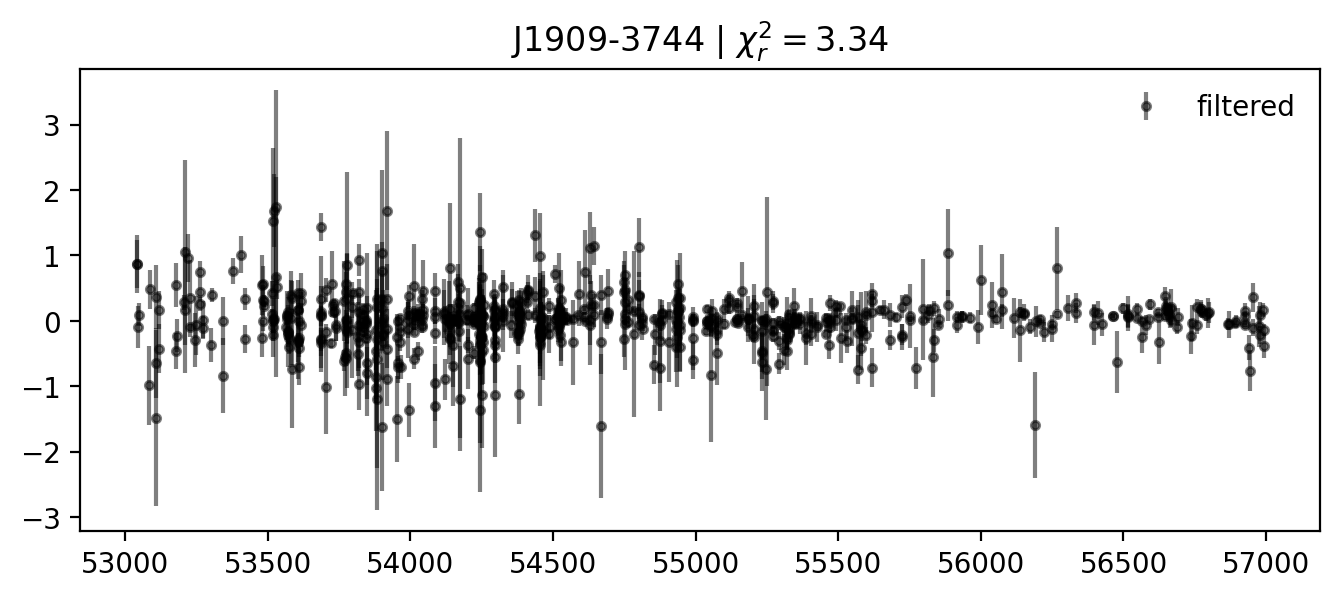



Results for PSR J1909-3744


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.142 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = 0
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       5.01690774390198          5.01690774384207          1.2726e-11    -5.9915e-11   Y
RAJ (hms)       19:09:47.4335837           19:09:47.4335829         1.7499e-07    -8.2389e-07  
DECJ (rad)      -0.658641278664147        -0.658641278610851        3.8045e-11    5.3296e-11    Y
DECJ (dms)      -37:44:14.51573           -37:44:14.51572           7.8474e-06    1.0993e-05   
F0 (s^-1)       339.315687218484          339.315687218484          8.0387e-14    -5.6843e-14   Y
F1 (s^-2)       -1.61481932440465e-15     -1.61481396549075e-

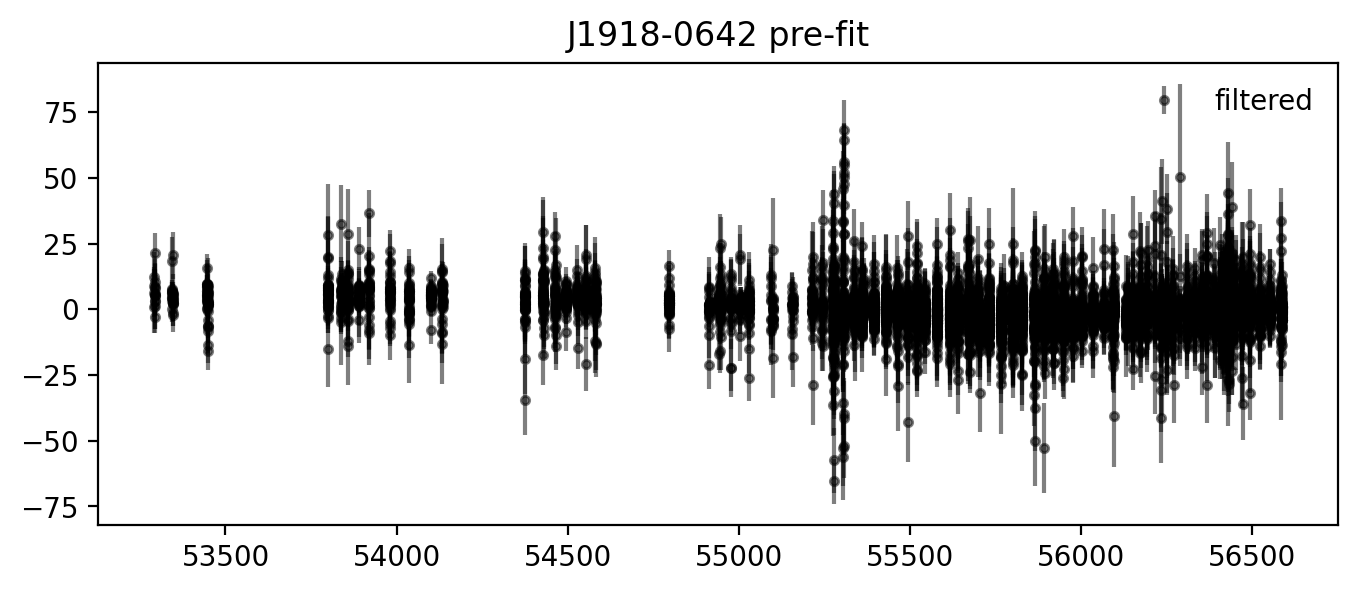

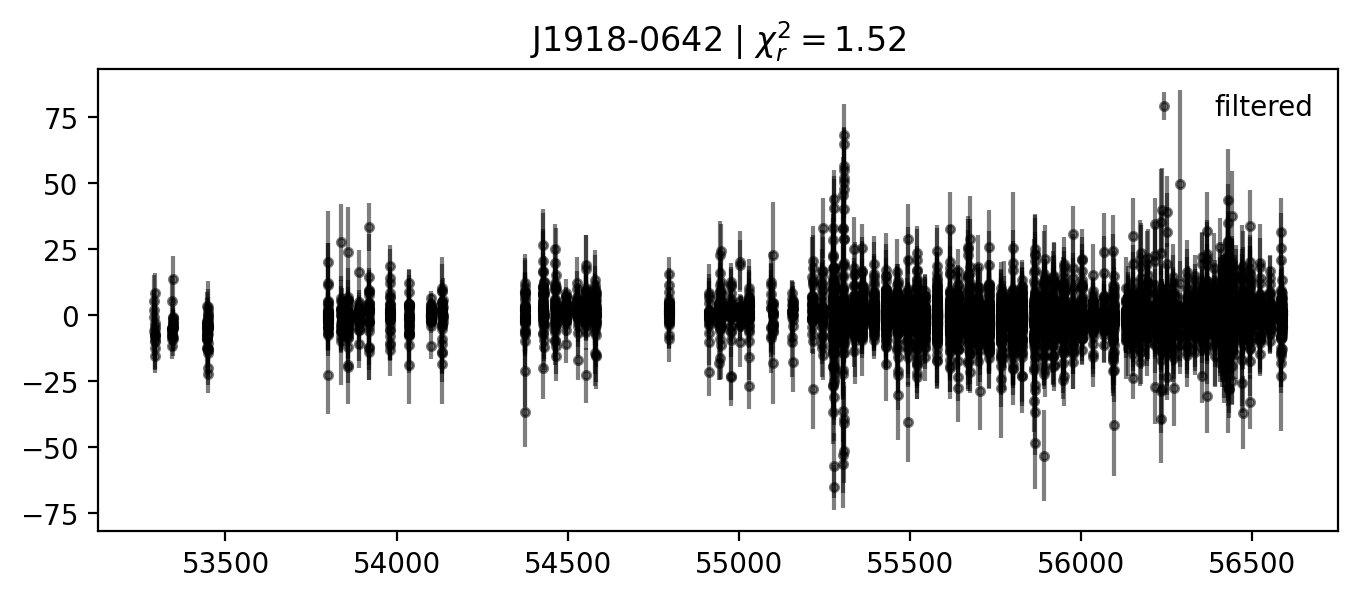



Results for PSR J1918-0642


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 2.066 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = 0
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       5.05622125273095          5.05622125314501          1.0876e-10    4.1406e-10    Y
RAJ (hms)       19:18:48.0331358           19:18:48.0331415         1.4956e-06    5.6937e-06   
DECJ (rad)      -0.117106208952891        -0.117106209181772        3.4114e-10    -2.2888e-10   Y
DECJ (dms)      -06:42:34.88950           -06:42:34.88955           7.0365e-05    -4.721e-05   
F0 (s^-1)       130.789514123372          130.789514123373          1.6062e-13    6.2528e-13    Y
F1 (s^-2)       -4.39471742521167e-16     -4.39484073070005e-

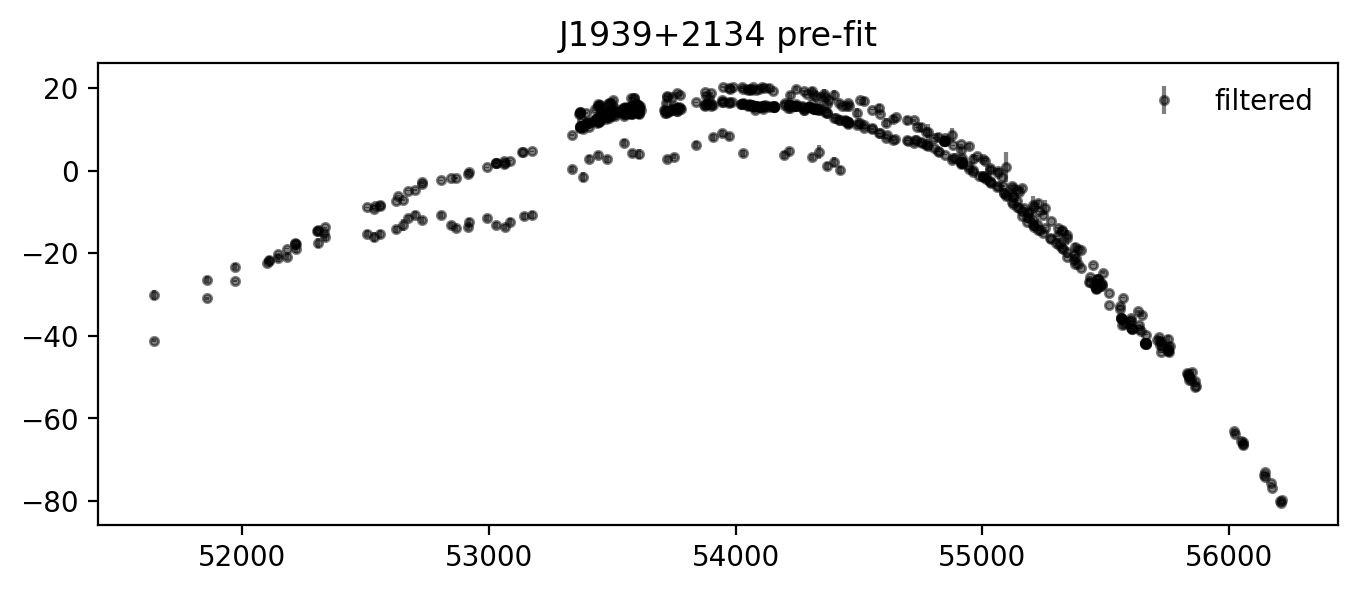

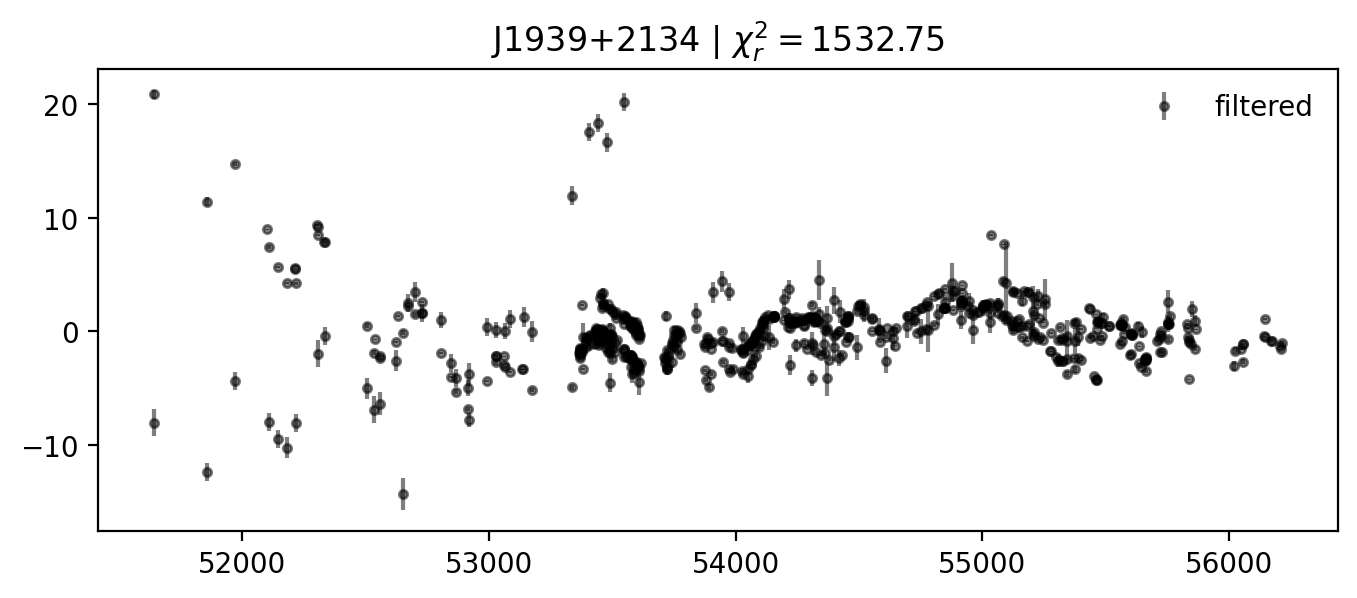



Results for PSR J1939+2134


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 2.063 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = 0
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       5.14716222340012          5.14716222336341          7.0932e-12    -3.6709e-11   Y
RAJ (hms)       19:39:38.5612488           19:39:38.5612483         9.7539e-08    -5.0479e-07  
DECJ (rad)      0.37669599057495          0.376695992129338         1.0662e-11    1.5544e-09    Y
DECJ (dms)      +21:34:59.12551           +21:34:59.12583           2.1992e-06    0.00032062   
F0 (s^-1)       641.928224582171          641.928224582507          2.5885e-13    3.3583e-10    Y
F1 (s^-2)       -4.33125539000271e-14     -4.3308775032338e-1

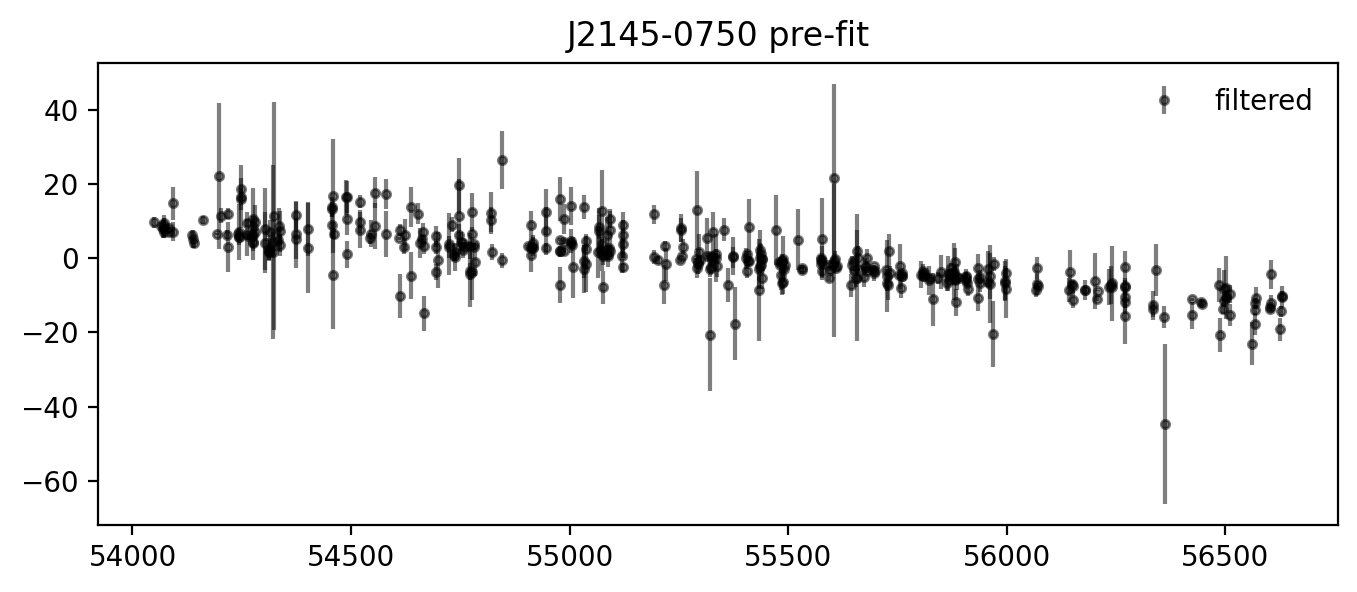

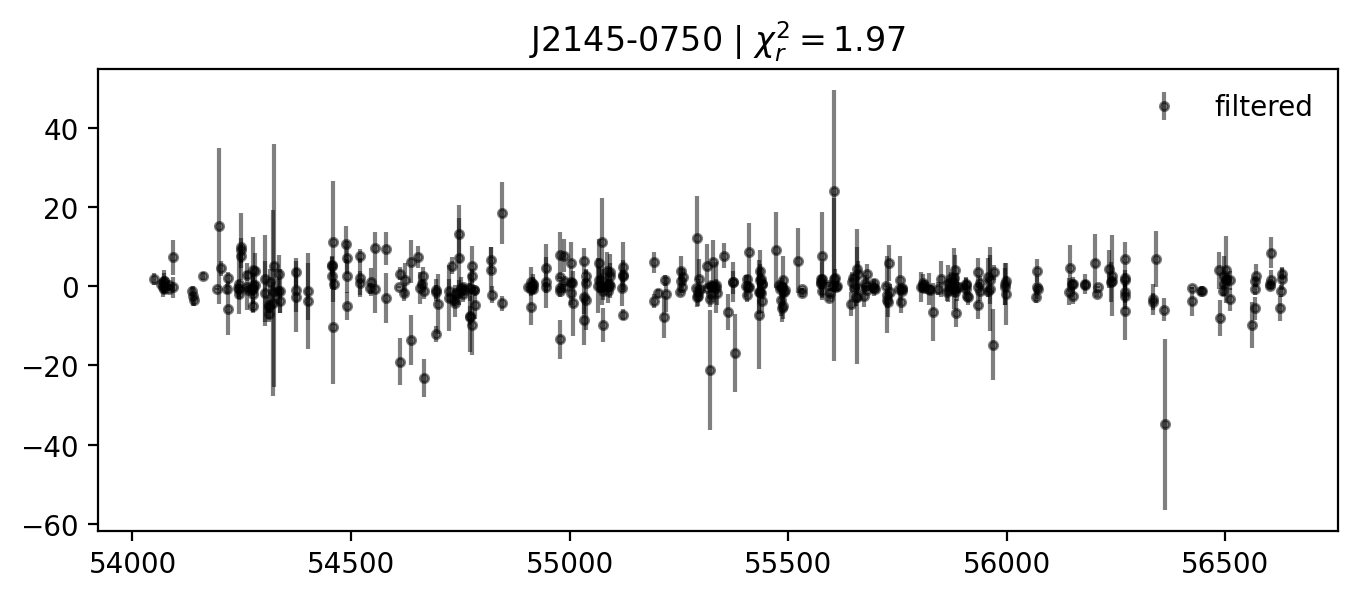



Results for PSR J2145-0750


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 1.041 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = 0
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       5.69780628343157          5.69780628425878          6.168e-10     8.2722e-10    Y
RAJ (hms)       21:45:50.4606057           21:45:50.4606171         8.4816e-06    1.1375e-05   
DECJ (rad)      -0.136807088874849        -0.136807091524072        1.7498e-09    -2.6492e-09   Y
DECJ (dms)      -07:50:18.48768           -07:50:18.48823           0.00036092    -0.00054644  
F0 (s^-1)       62.2958878373838          62.295887837389           1.5628e-13    5.1656e-12    Y
F1 (s^-2)       -1.15635511693216e-16     -1.15607396883537e-

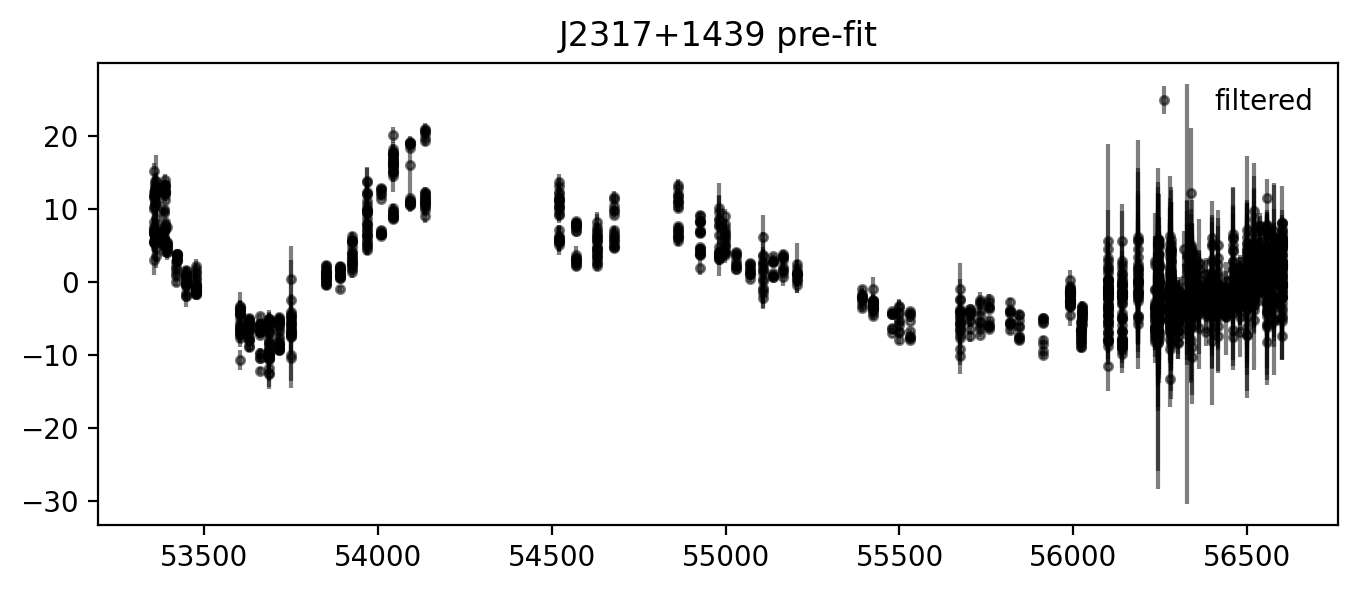

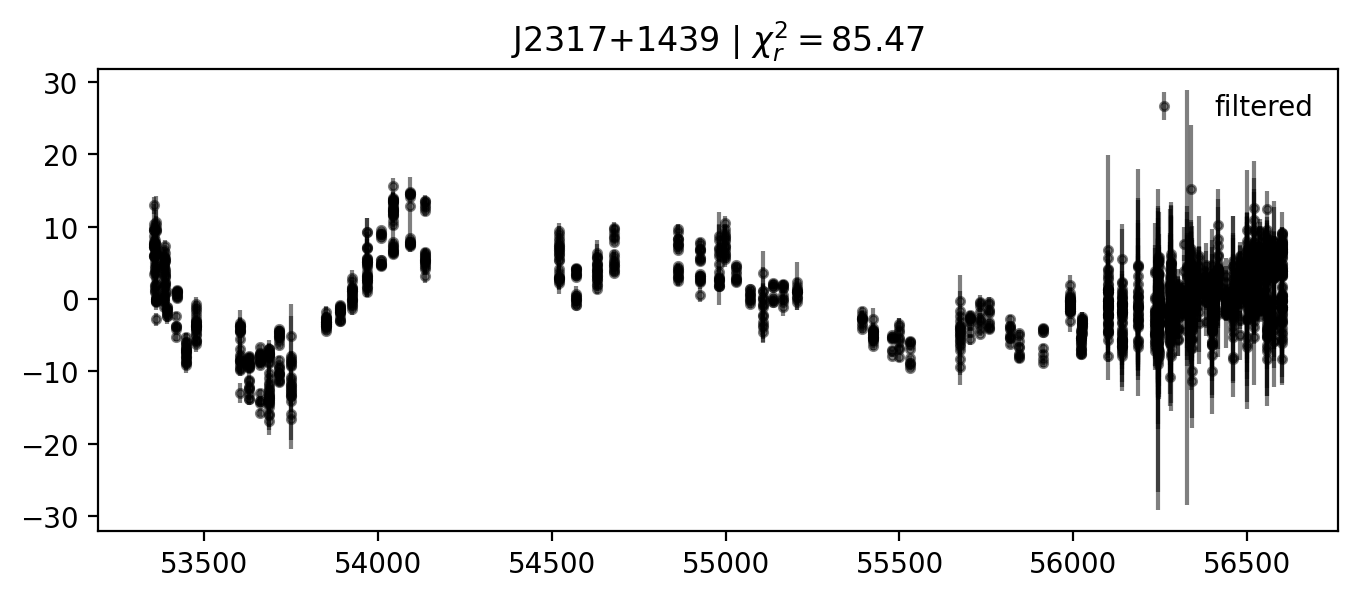



Results for PSR J2317+1439


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 4.353 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = 0
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       6.09623412072607          6.09623412167128          5.0497e-11    9.4522e-10    Y
RAJ (hms)       23:17:09.2366499           23:17:09.2366629         6.9438e-07    1.2998e-05   
DECJ (rad)      0.255842268005635         0.255842263078277         1.0109e-10    -4.9274e-09   Y
DECJ (dms)      +14:39:31.25584           +14:39:31.25482           2.0852e-05    -0.0010163   
F0 (s^-1)       290.25460366487           290.254603664872          1.2636e-13    1.6485e-12    Y
F1 (s^-2)       -2.04714670390642e-16     -2.04633507296318e-

In [21]:
outdir = os.path.join(project_path, 'data/lite_partim_final_refit')
indir = os.path.join(project_path, 'data/lite_partim_final')

#start_pulsar = 'J1455'
#continue_ = True
for pname, filters in sorted(psrdict.items()):
    #if pname == start_pulsar:
    #    continue_ = False
    #if continue_:
    #    continue
    parfile = os.path.join(indir, '{}.par'.format(pname))
    timfile = os.path.join(indir, '{}.tim'.format(pname))
    psr = t2.tempopulsar(parfile, timfile, maxobs=30000)
    
    plt.figure(figsize=(8,3))
    plt.errorbar(x=psr.toas(), y=psr.residuals()*1e6, yerr=psr.toaerrs, fmt='.k', alpha=0.5, label='filtered')
    plt.legend(loc='best', frameon=False)
    plt.title(f'{psr.name} pre-fit')
    plt.show()
    
    xfit, stderr, cov, chisq = psr.fit(iters=6, include_noise=False)
    
    plt.figure(figsize=(8,3))
    plt.errorbar(x=psr.toas(), y=psr.residuals()*1e6, yerr=psr.toaerrs, fmt='.k', alpha=0.5, label='filtered')
    plt.legend(loc='best', frameon=False)
    plt.title(fr'{psr.name} | $\chi^2_r = {chisq/len(psr.toas()):0.2f}$')
    plt.show()

    newpar = os.path.join(outdir, '{}.par'.format(pname))
    newtim = os.path.join(outdir, '{}.tim'.format(pname))
    psr.savepar(newpar)
    psr.savetim(newtim)
    dr2u.remove_addsat(newtim)
    
    del(psr)
    plt.close('all')

# make sure min_toas is the same
#dr2u.make_dataset(psrdict, indir=lite_dir, outdir=rundir,
#                  bw=BW, dt=DM_window, min_toas=10, plot=True, fit=True)

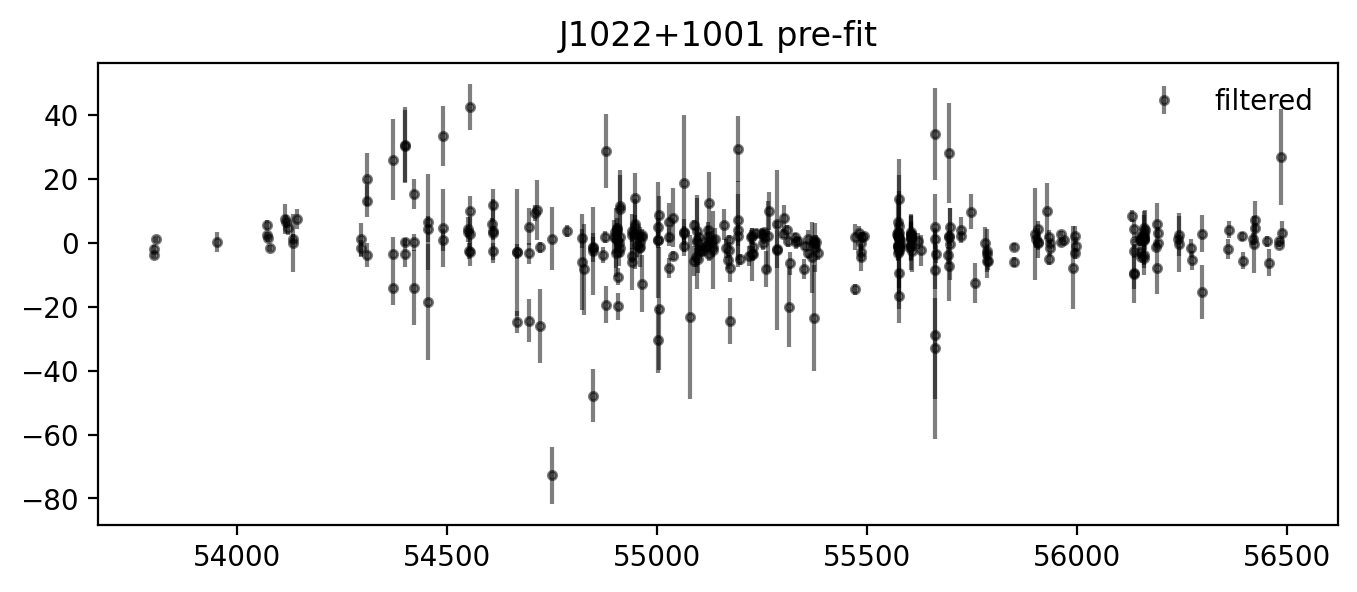

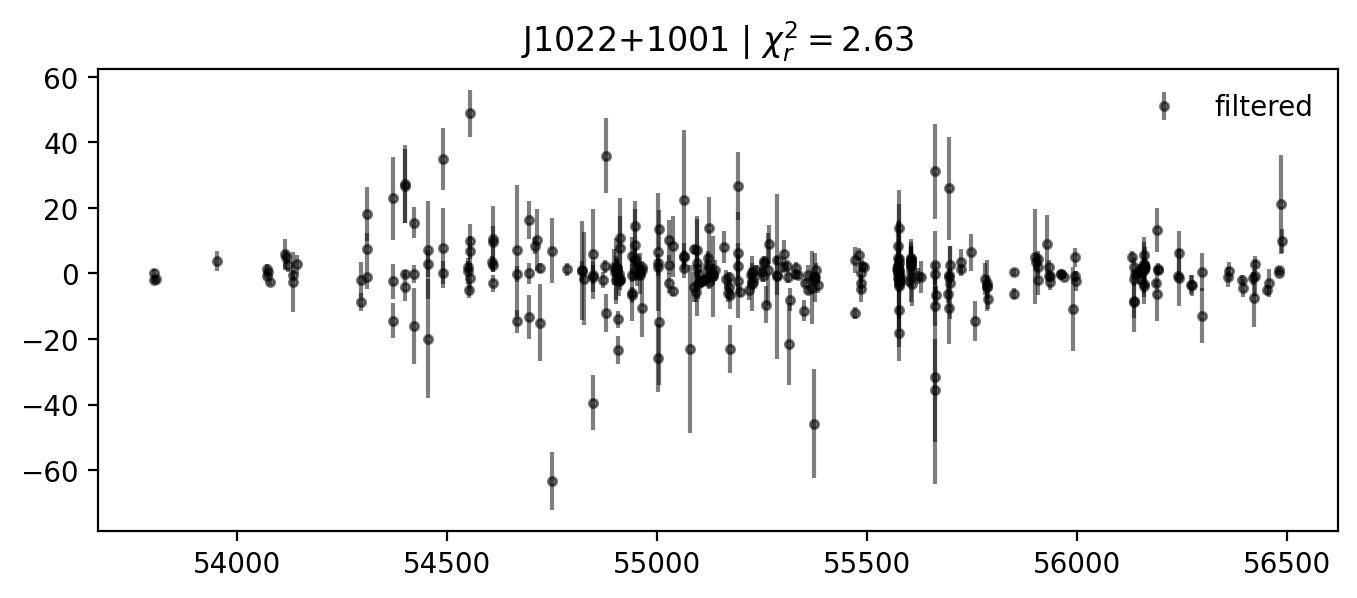

In [27]:
pname = 'J1022+1001'
parfile = os.path.join(indir, '{}.par'.format(pname))
timfile = os.path.join(indir, '{}.tim'.format(pname))
psr = t2.tempopulsar(parfile, timfile, maxobs=30000)

plt.figure(figsize=(8,3))
plt.errorbar(x=psr.toas(), y=psr.residuals()*1e6, yerr=psr.toaerrs, fmt='.k', alpha=0.5, label='filtered')
plt.legend(loc='best', frameon=False)
plt.title(f'{psr.name} pre-fit')
plt.show()

xfit, stderr, cov, chisq = psr.fit(iters=6, include_noise=False)

plt.figure(figsize=(8,3))
plt.errorbar(x=psr.toas(), y=psr.residuals()*1e6, yerr=psr.toaerrs, fmt='.k', alpha=0.5, label='filtered')
plt.legend(loc='best', frameon=False)
plt.title(fr'{psr.name} | $\chi^2_r = {chisq/len(psr.toas()):0.2f}$')
plt.show()

In [72]:
psr.noisemodel

OrderedDict([('log10_ared', nan), ('gamma', nan), ('nred', -1)])